<div style="background-color:#e0f0ff; padding:20px; border-radius:10px;">
  <b style="color:#003366; font-size:2.5em;">Sticky Prices, Shifting Behaviour: Untangling Supply and Demand in U.S. Gasoline Markets</b>
</div>


## **Research Motivation**

Petrol markets exhibit complex interactions between price, supply, and consumer behaviour. This project investigates whether **prices drive consumer behaviour** or if **demand and supply dynamics push prices** — especially in light of **sticky prices** observed in administered markets.


## **The Theory Behind Our Work**

### A Keynesian View on Sticky Prices

According to Keynesian theory:
- In the **short run**, prices (especially for essential goods like petrol) do not adjust instantaneously.
- Instead, **quantities adjust**, making **behavioural responses (e.g., driving less)** a key margin for equilibrium.
  
This implies that:

> **Petrol price changes → changes in consumer behaviour**, rather than the reverse.

However, real-world markets are noisy:
- **Supply shocks** (e.g., refinery outages, OPEC decisions) may cause **price changes unrelated to demand**.
- **Macroeconomic and behavioural factors** (e.g., seasonal driving, economic cycles) may shift demand and indirectly affect prices.

<div style="border-left: 5px solid #2196F3; background-color: #E3F2FD; padding: 15px; margin-bottom: 20px;">
  <h3><strong>Hypothesis</strong></h3>
  <ul>
    <li><strong>H₀ (Null):</strong> Changes in petrol demand and supply levels cause immediate price fluctuations in the same period.</li>
    <li><strong>H₁ (Alternative):</strong> Changes in petrol demand and supply levels cause lagged price fluctuations.</li>
  </ul>
</div>


In [1]:
# Imports
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import ruptures as rpt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import production and consumer data
prices_weekly = pd.read_csv('./data/weekly_gasoline_prices.csv')
supply_weekly = pd.read_csv('./data/weekly_supply_estimates.csv')
transport_monthly = pd.read_csv('./data/monthly_transportation_statistics.csv')

## **0. Data Preprocessing and Exploratory Data Analysis (EDA)**

We utilize the following datasets to examine trends in gasoline pricing, supply-demand dynamics, and transportation behavior. For each dataset, we identify specific variables of interest:

| **Dataset**                          | **Selected Variable**                                                                 | **Descriptions**                  |
|-------------------------------------|----------------------------------------------------------------------------------------|---------------------------------------|
| **Weekly Petrol Prices**            | `Price`                                                                                | Price reported for that week |
| **Weekly Supply Estimates**         | `Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)`             | Total production of conventional motor gasoline which is defined as: finished motor gasoline not included in the oxygenated or reformulated gasoline categories                |
| **Monthly Transport Statistics**    | `Highway Vehicle Miles Travelled - All Systems`                                        | The Federal Highway Administration estimates vehicle miles travelled on all roads and streets in each month             |

### **0.1 `prices_weekly`**

We filter the dataset to focus exclusively on retail gasoline prices across all grades and formulations in the United States, then clean up unneeded columns for clarity and ease of analysis.

1. **Filter for gasoline price type**
* Keep only rows where 'Type' is 'All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)'.

2. **Filter geography**
* Keep only rows where 'Geography' is 'US'.

3. **Drop irrelevant columns**
* Remove 'Type', 'Type_Clean', and 'Unit' columns — these are now redundant.

In [3]:
# Filter for the relevant gasoline price type
prices = prices_weekly.copy()[prices_weekly['Type'] == 'All Grades All Formulations Retail Gasoline Prices  (Dollars per Gallon)']

# Keep only U.S. data
prices = prices[prices['Geography'] == 'US']

# Drop unnecessary columns
prices = prices.drop(columns=['Type', 'Type_Clean', 'Unit', 'Geography', 'Year']).reset_index(drop=True)

# Rename
prices = prices.rename(columns={
    'Date': 'date',
    'Year': 'year',
    'Price': 'price'
})

### **0.2 `supply_weekly`**

In [4]:
supply = supply_weekly.copy()[['Date', 'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)']]
supply = supply.rename(columns={
    'Date': 'date',
    'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)': 'motor_gasoline_barrels'
})

#### **Rationale for Using Weekly U.S. Ending Stocks of Finished Motor Gasoline as a Proxy for Supply and Demand**

The variable **`Weekly U.S. Ending Stocks of Finished Motor Gasoline (Thousand Barrels)`** represents the total inventory of conventional motor gasoline held in stock at the end of each week. This measure reflects the **finished motor gasoline** that is **not included in oxygenated or reformulated gasoline categories**, focusing solely on conventional gasoline production.

As such, it serves as a reliable **proxy for gasoline supply** for several reasons:

- **Inventory Levels Represent Supply Availability:** Ending stocks indicate how much gasoline is physically available in the market after production, imports, and consumption within the week.
- **Conventional Gasoline Focus:** By isolating finished conventional motor gasoline, this measure avoids complications from alternative fuel blends, providing a clearer view of mainstream gasoline supply.
- **Market Balancing Act:** Changes in ending stocks reflect the balance between supply and demand; when stocks decline, it often signals higher consumer demand relative to production, and vice versa.

While this variable primarily measures supply, it also **indirectly captures consumer demand dynamics**:

- **Demand Reduces Stocks:** Higher consumption by consumers reduces the inventory of finished motor gasoline, causing ending stocks to fall.
- **Supply-Demand Interaction:** Thus, weekly fluctuations in ending stocks embody the net effect of production and consumer usage, making it a practical, observable proxy that links supply with real-time demand pressure in the market.

In summary, by tracking **Weekly U.S. Ending Stocks of Finished Motor Gasoline**, we capture a vital indicator of gasoline availability and consumption behaviour, enabling insightful analysis of supply-demand trends in the U.S. gasoline market.

### **0.3 `transport`**

In [5]:
demand = transport_monthly.copy()[['Date', 'Highway Vehicle Miles Traveled - All Systems']].copy()
demand = demand.rename(columns={
    'Date': 'date',
    'Highway Vehicle Miles Traveled - All Systems': 'miles_travelled'
})

### **0.4 Preprocessing**

#### **Visualising missing data**

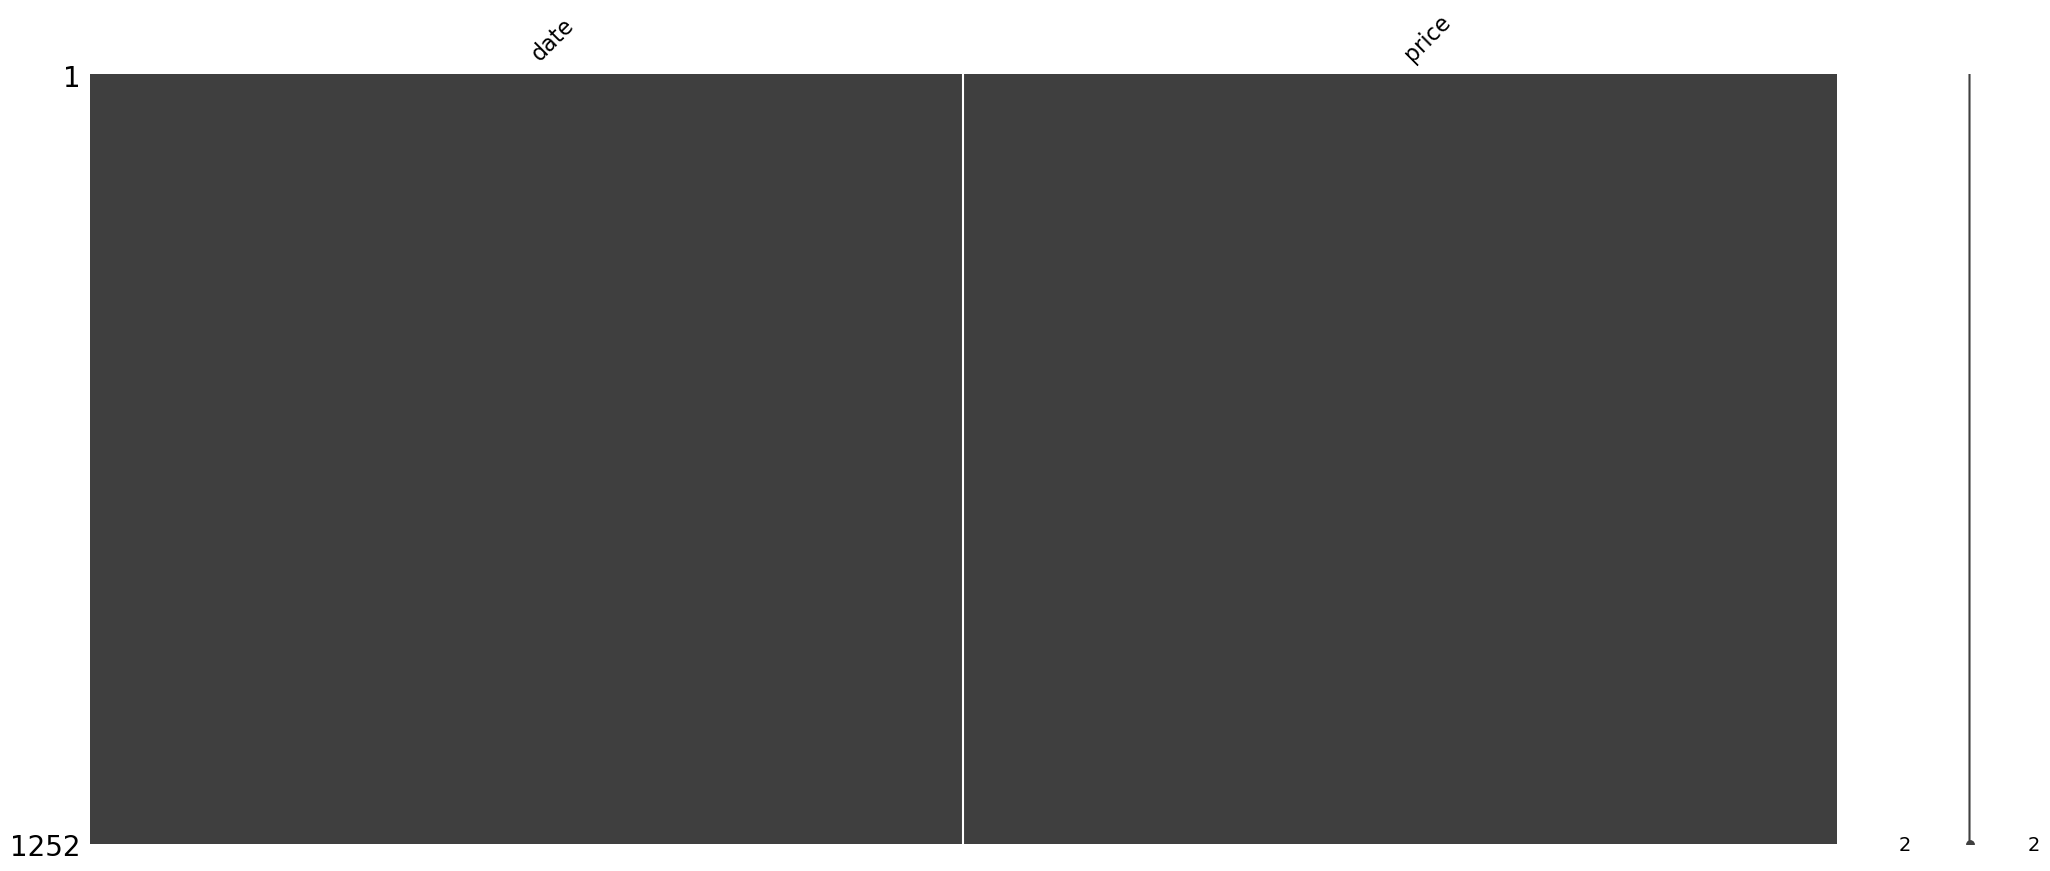

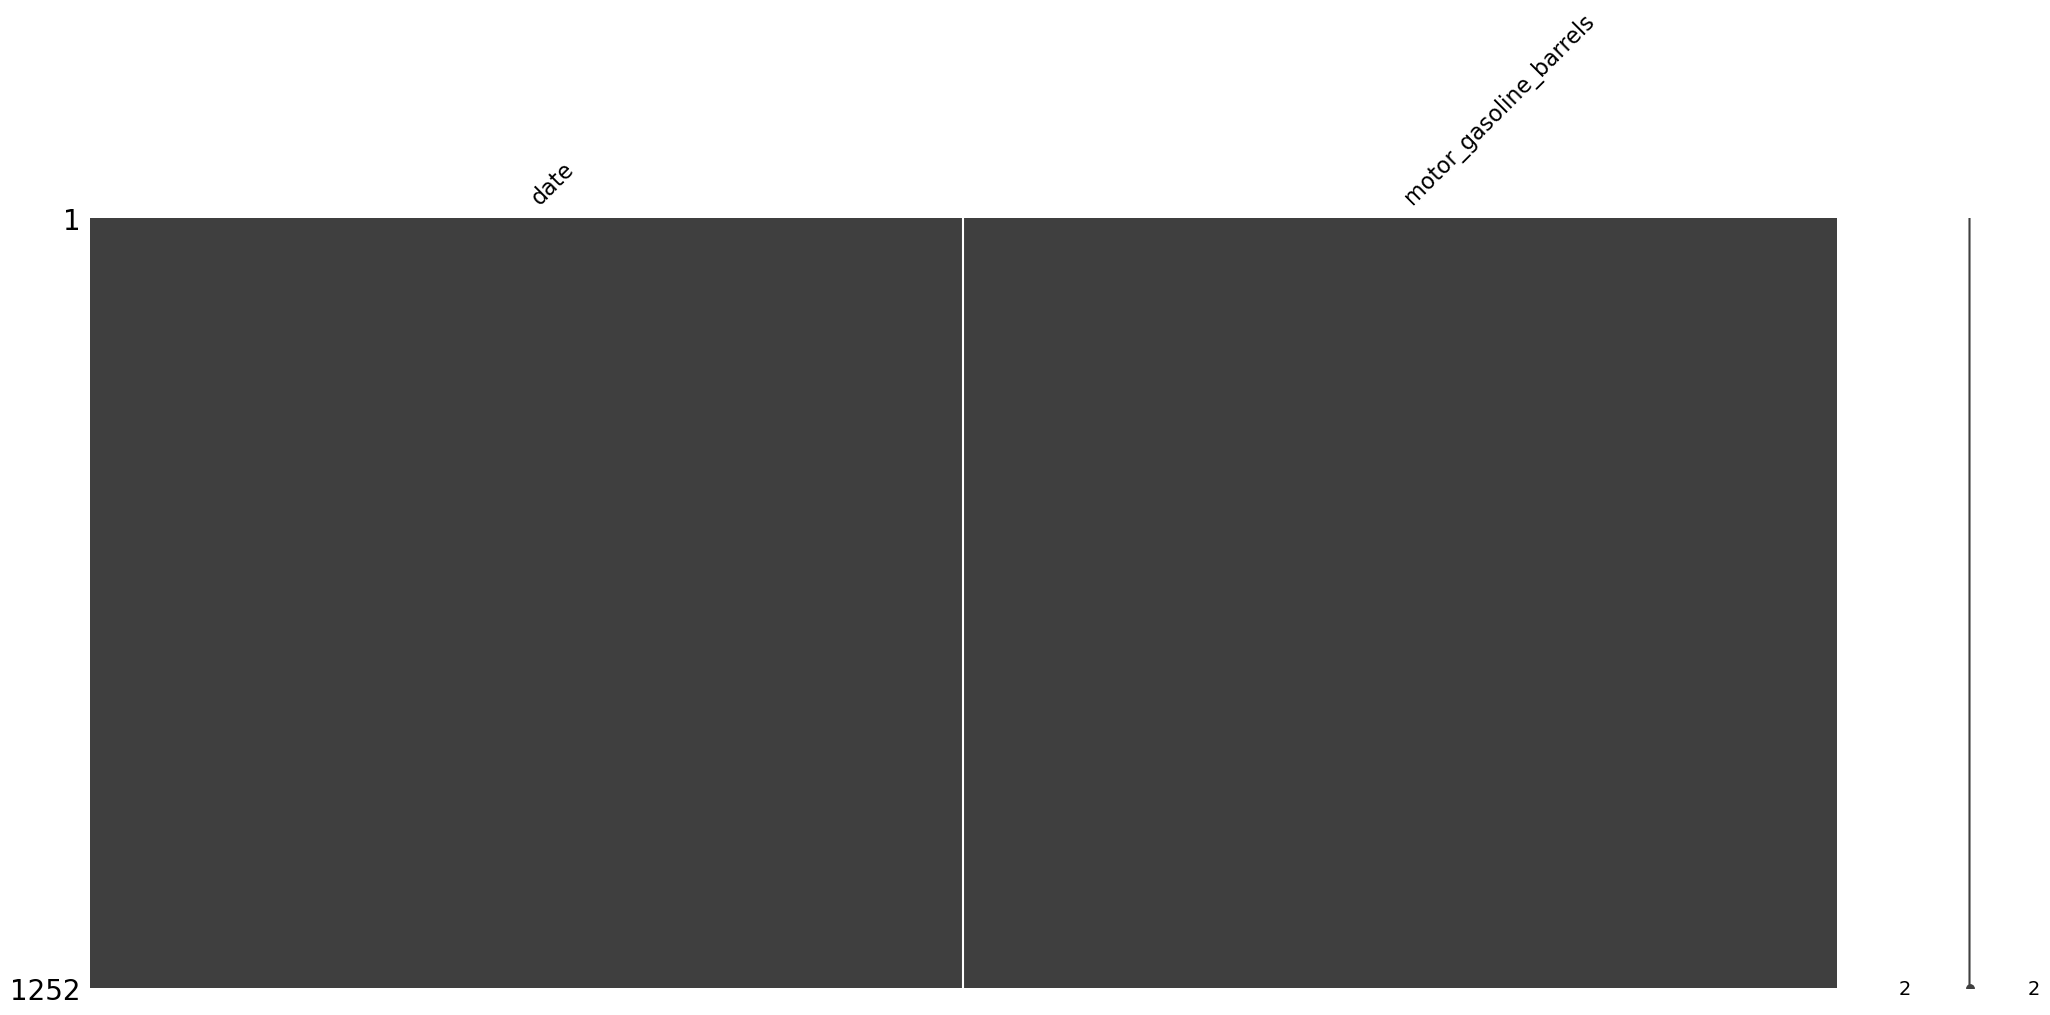

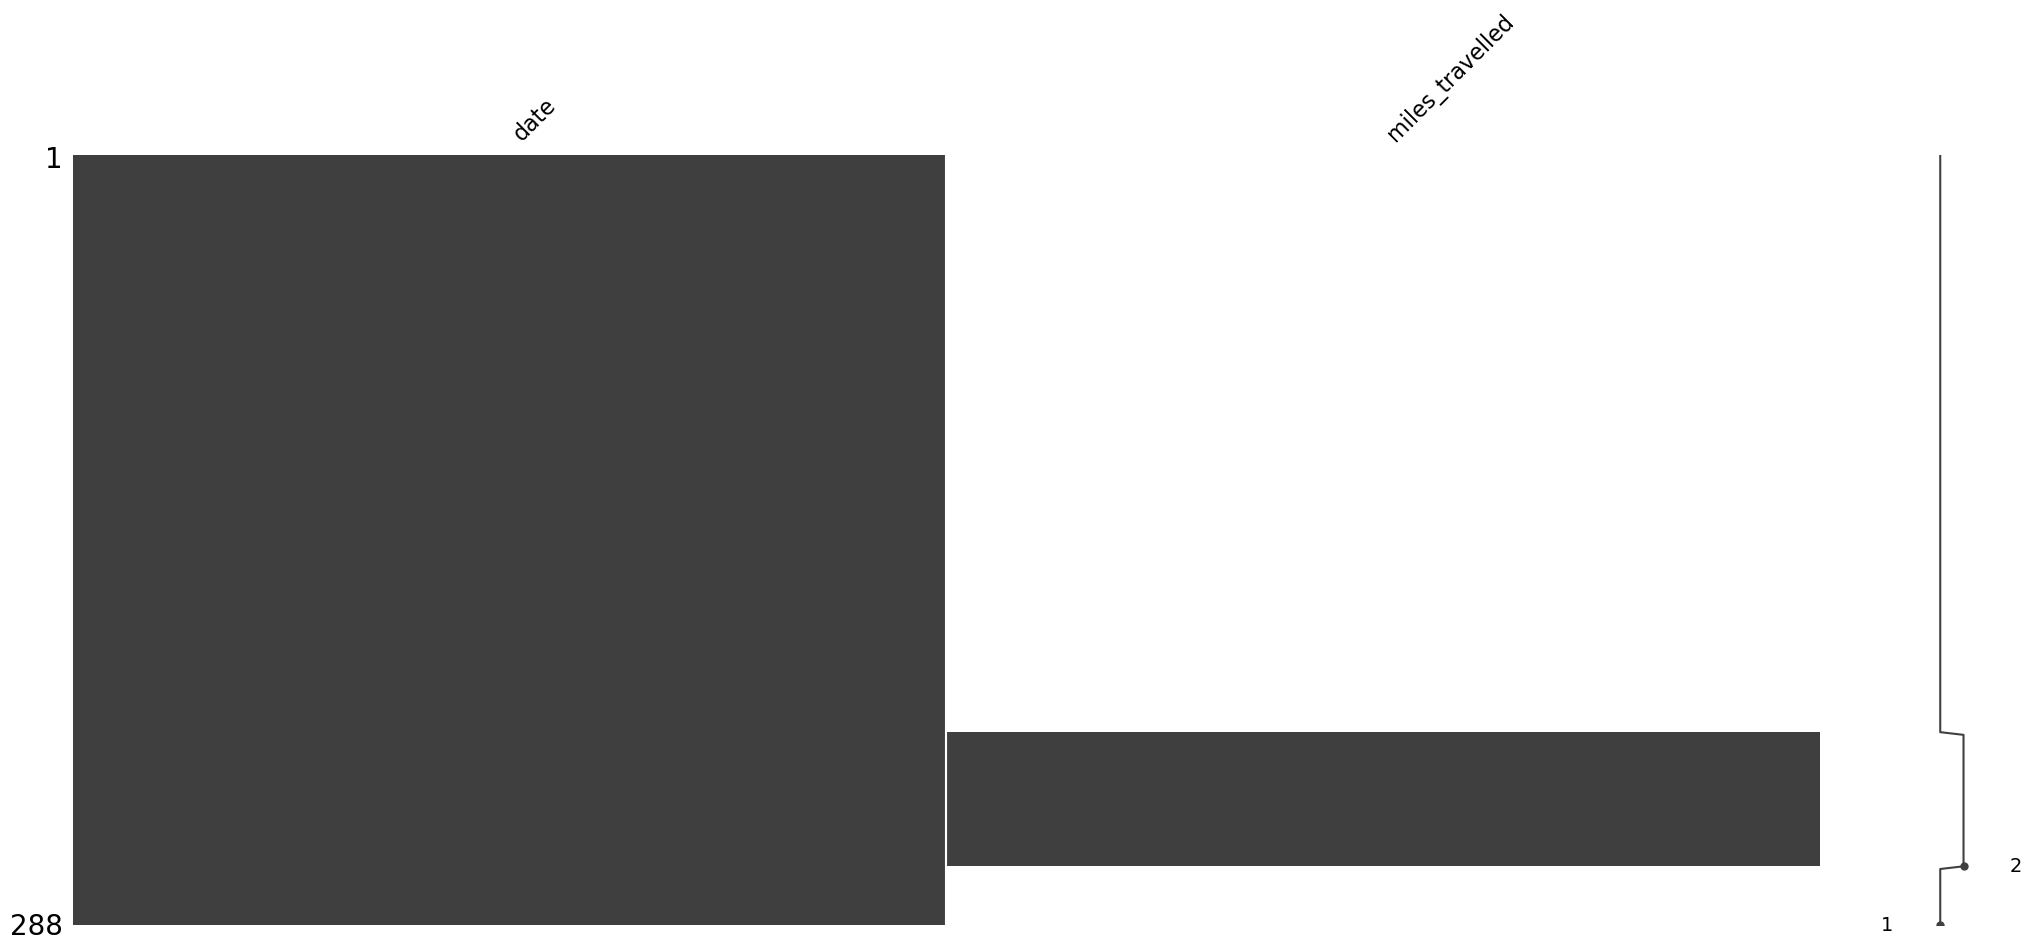

In [6]:
for df in [prices, supply, demand]:
    msno.matrix(df)
    plt.show()

In [7]:
# Drop NaNs in 'miles_travelled' and work on a copy to avoid SettingWithCopyWarning
demand = demand.dropna(subset=['miles_travelled']).copy()

# Convert 'date' to datetime
demand['date'] = pd.to_datetime(demand['date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

# Drop rows where datetime conversion failed
demand = demand.dropna(subset=['date'])

# Get min and max dates
start_date = demand['date'].min()
end_date = demand['date'].max()
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

print(f"Date range of demand: {start_date_str} to {end_date_str}")

# Format date column to "YYYY-MM-DD"
demand['date'] = demand['date'].dt.strftime('%Y-%m-%d')

# Reset index
demand = demand.reset_index(drop=True)

Date range of demand: 2018-01-01 to 2022-02-01


In [8]:
# Ensure date columns are in datetime format
prices['date'] = pd.to_datetime(prices['date'])
demand['date'] = pd.to_datetime(demand['date'])
supply['date'] = pd.to_datetime(supply['date'])

In [9]:
# Define date range
start_date = '2018-01-01'
end_date = '2022-12-31'

# Filter both DataFrames by the date range
prices = prices[(prices['date'] >= start_date) & (prices['date'] <= end_date)].reset_index(drop=True)
supply = supply[(supply['date'] >= start_date) & (supply['date'] <= end_date)].reset_index(drop=True)

### **0.5 Visualising Overall Trends**

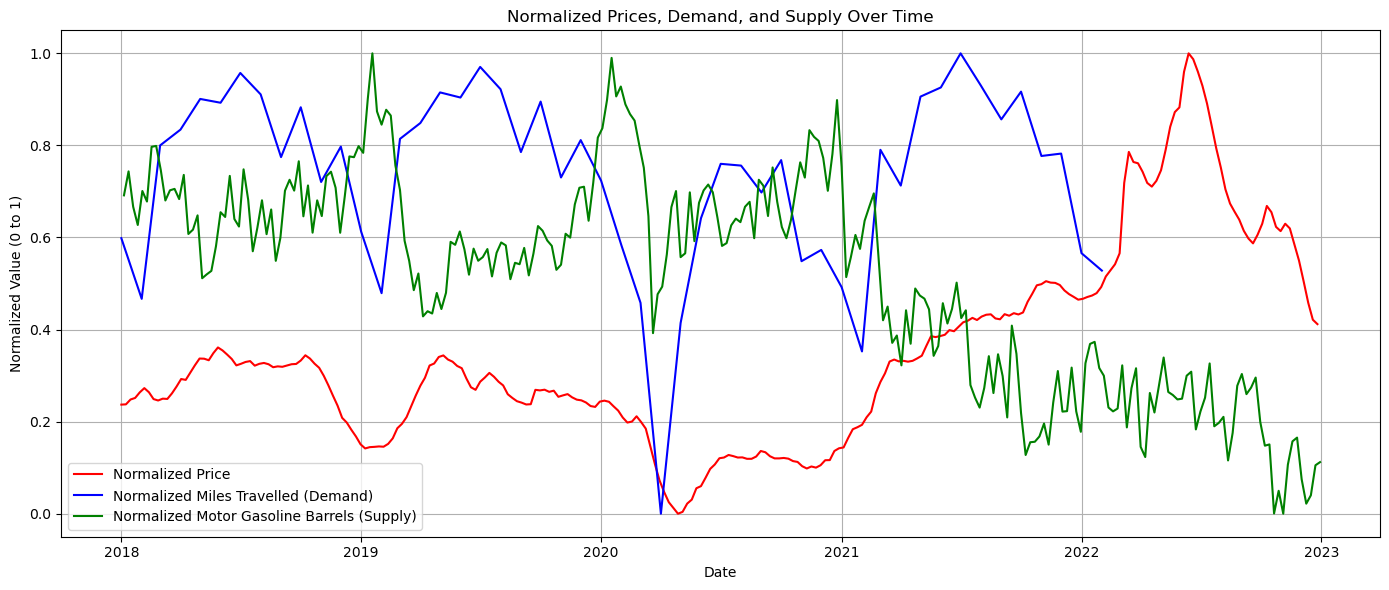

In [10]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

# Apply normalization
prices['price_norm'] = normalize(prices['price'])
demand['miles_travelled_norm'] = normalize(demand['miles_travelled'])
supply['motor_gasoline_barrels_norm'] = normalize(supply['motor_gasoline_barrels'])

plt.figure(figsize=(14, 6))

plt.plot(prices['date'], prices['price_norm'], label='Normalized Price', color='red')
plt.plot(demand['date'], demand['miles_travelled_norm'], label='Normalized Miles Travelled (Demand)', color='blue')
plt.plot(supply['date'], supply['motor_gasoline_barrels_norm'], label='Normalized Motor Gasoline Barrels (Supply)', color='green')

plt.xlabel('Date')
plt.ylabel('Normalized Value (0 to 1)')
plt.title('Normalized Prices, Demand, and Supply Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

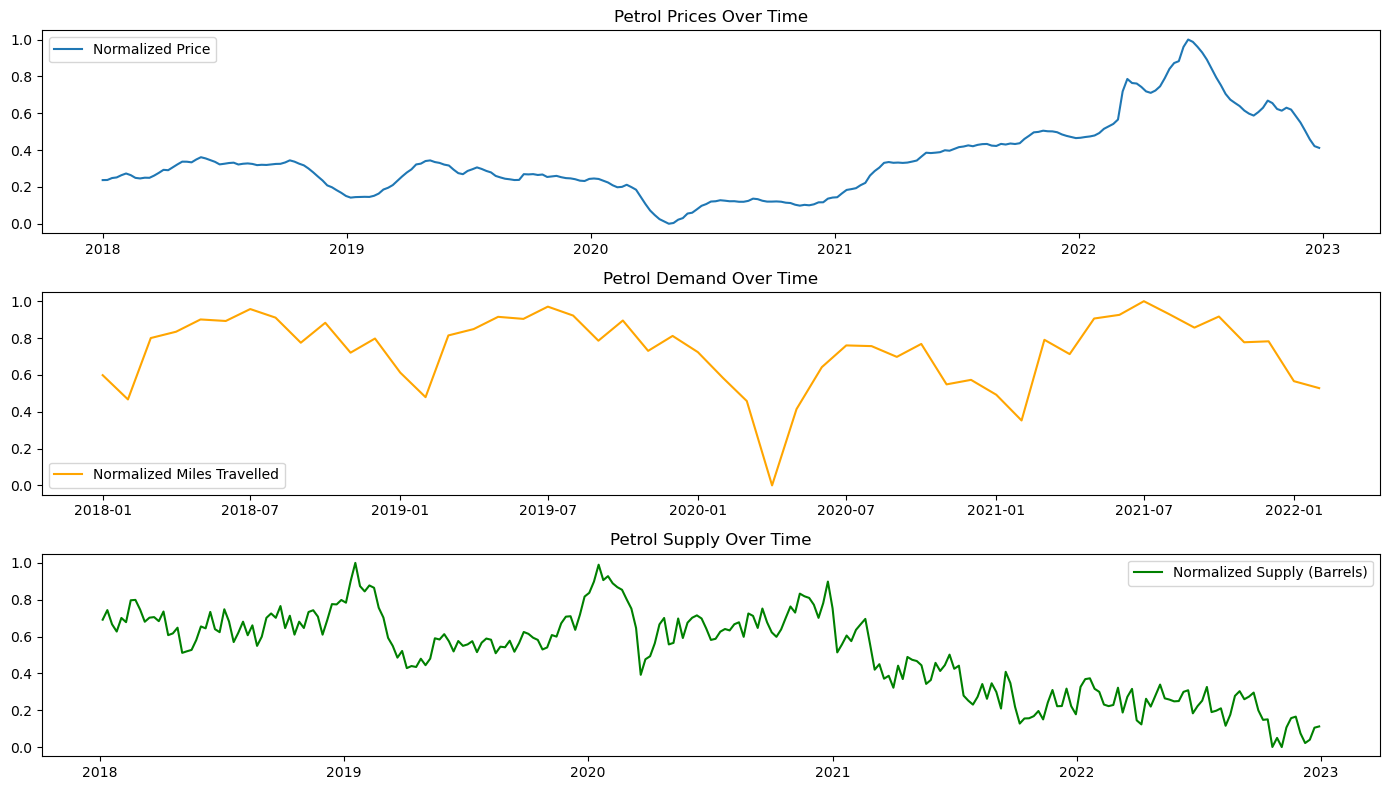

In [11]:


plt.figure(figsize=(14,8))

plt.subplot(3,1,1)
plt.plot(prices['date'], prices['price_norm'], label='Normalized Price')
plt.title('Petrol Prices Over Time')
plt.legend()

plt.subplot(3,1,2)
plt.plot(demand['date'], demand['miles_travelled_norm'], label='Normalized Miles Travelled', color='orange')
plt.title('Petrol Demand Over Time')
plt.legend()

plt.subplot(3,1,3)
plt.plot(supply['date'], supply['motor_gasoline_barrels_norm'], label='Normalized Supply (Barrels)', color='green')
plt.title('Petrol Supply Over Time')
plt.legend()

plt.tight_layout()
plt.show()


#### **Analysis**
1. **Prices**
   - Fairly stable until 2020, then sharp dip followed by strong rally peaking in 2022.
   - Matches known trends in global fuel markets (pandemic crash + post-pandemic inflation + supply constraints).

2. **Demand**
   - Peaks consistently during mid-years (summer driving seasons).
   - Severe dip during early 2020.
   - Recovers strongly by 2021, then slowly declines post-2022, possibly due to economic slowdown or behavior change.

3. **Supply**
   - More volatile and erratic.
   - Peak supply precedes price peaks (supply often leads prices, visible in 2019 and 2021).
   - Overall declining trend from mid-2021 through 2023.

#### **Leading & Lagging Relationships**
*Preliminary Analysis*

| Scenario                                        | Observed?             | Timing Relationship           | Evidence from Plots                                                                                                                                                 | Supports H₁ (Lagged Effect)? |
|------------------------------------------------|-----------------------|-------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------|
| **Demand ↑ and Price ↑ in same period**         | No (not consistent) | **Prices tend to lag** demand | In 2021, normalized demand (blue) rises significantly ahead of the steep price (red) rise in 2022. Price increases follow rising travel activity with delay.        | **Yes**                    |
| **Price increases lag behind demand increases** | Yes                 | Clear lag                     | Repeated pattern in mid-2020 to 2022: demand picks up before prices respond.                                                                                        | **Yes**                    |
| **Supply ↓ and Price ↑ in same period**         | Sometimes           | Often simultaneous            | In late 2021 and early 2022, supply (green) and price (red) move in opposite directions **within the same time window**, suggesting a contemporaneous supply shock. | ⚠️ **Partially**             |
| **Price increases lag behind supply decreases** | Sometimes           | Mild lag                      | In some intervals (e.g., late 2020), a drop in supply precedes a price rise, but timing is less consistent than with demand.                                        | **Yes (weaker)**           |


#### **Significant Trends**

- **Pandemic Impact (2020):** All variables crashed simultaneously—a major exogenous shock.

- **2021–2022 Recovery:** Demand and prices rebounded; supply did not fully recover → upward pressure on prices.

- **2022 Peak:** Price spikes while supply falls and demand remains elevated.

- **2023 Decline:** All variables decline—possible economic cooling or policy effects.

### **0.6 Structural Break Analysis**  
*Detecting breaks in trends*

For the structural break analysis of gasoline prices, miles travelled by vehicles, and gasoline barrels production, **raw (unnormalized) data** was used instead of normalized data.

This decision was made to capture **actual changes in the data** — such as real fluctuations in gasoline prices and production volumes — which are critical for understanding meaningful shifts in the market and industry.

Using raw data preserves the true scale and magnitude of these variables, allowing the analysis to detect breaks that correspond to significant economic or operational events.

Normalization, while useful for comparing variables on different scales, can mask the absolute size of changes and was therefore not applied in this context.

In [12]:
def structural_break(column, title, xlabel="Index", ylabel="Value", date_column=None, penalty=10):
    # 1. Extract the time series (1D or multivariate)
    series = column.values

    # 2. Choose the model and algorithm
    algo = rpt.Pelt(model="l2").fit(series)

    # 3. Select penalty
    try:
        breakpoints = algo.predict(pen=penalty)
    except rpt.exceptions.BadSegmentationParameters:
        print("Segmentation failed: not enough data or invalid parameters.")
        return

    # 4. Plot results with breakpoints
    # Manual plotting
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(series, label="Series")

    for bp in breakpoints[:-1]:  # Ignore last point (end of series)
        ax.axvline(bp, color="red", linestyle="--", label="Breakpoint" if bp == breakpoints[0] else "")

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if date_column is not None:
        ax.set_xticks(range(0, len(date_column), 52))
        ax.set_xticklabels(date_column[::52], rotation=45)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # 5. Print break dates (ignore last point which is end of series)
    if date_column is not None:
        valid_indices = [b - 1 for b in breakpoints[:-1] if 0 <= b - 1 < len(date_column)]
        break_dates = date_column.iloc[valid_indices]
        print("Detected break dates:")
        print(break_dates)
    else:
        print("Detected break indices:")
        print(breakpoints[:-1])

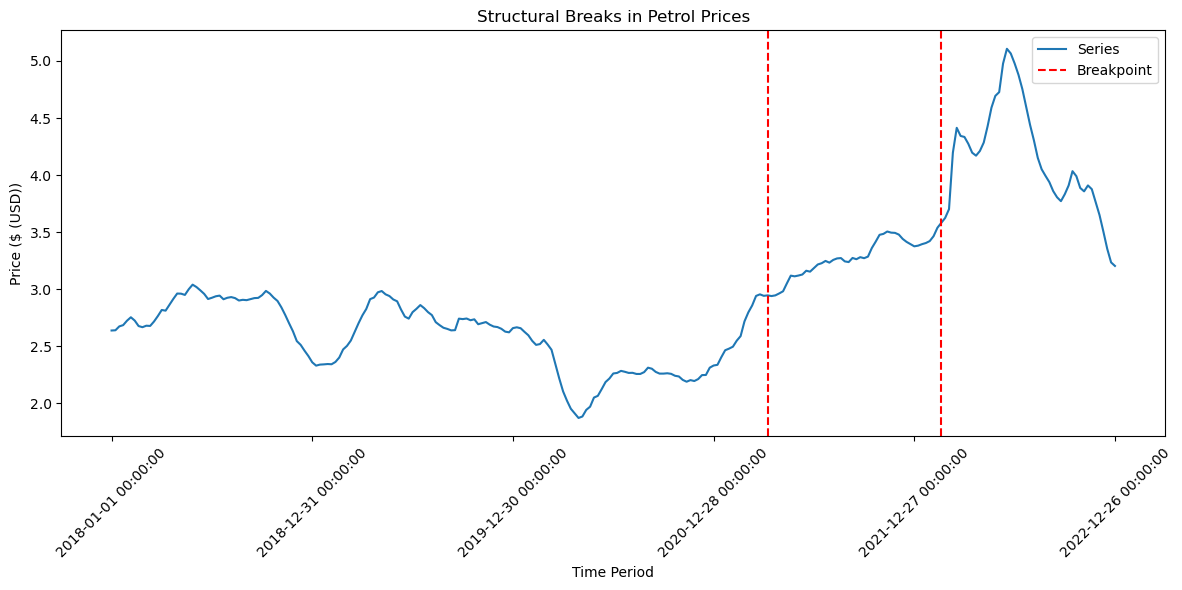

Detected break dates:
169   2021-03-29
214   2022-02-07
Name: date, dtype: datetime64[ns]


In [13]:
structural_break(
    column=prices['price'], 
    title="Structural Breaks in Petrol Prices",
    xlabel="Time Period", 
    ylabel="Price ($ (USD))",
    date_column=prices['date']
)

#### **Structural Break Analysis for Gasoline Prices**

**Detected Break Dates:**
- **2021-03-29**: Marks a significant shift due to post-COVID demand recovery, OPEC+ supply constraints, and fiscal stimulus in the U.S. These factors contributed to a sharp rise in crude oil and gasoline prices.
- **2022-02-07**: Occurs shortly before the Russian invasion of Ukraine (Feb 24, 2022), likely reflecting market anticipation of geopolitical tensions and supply disruptions, leading to increased price volatility and a subsequent spike in fuel prices.


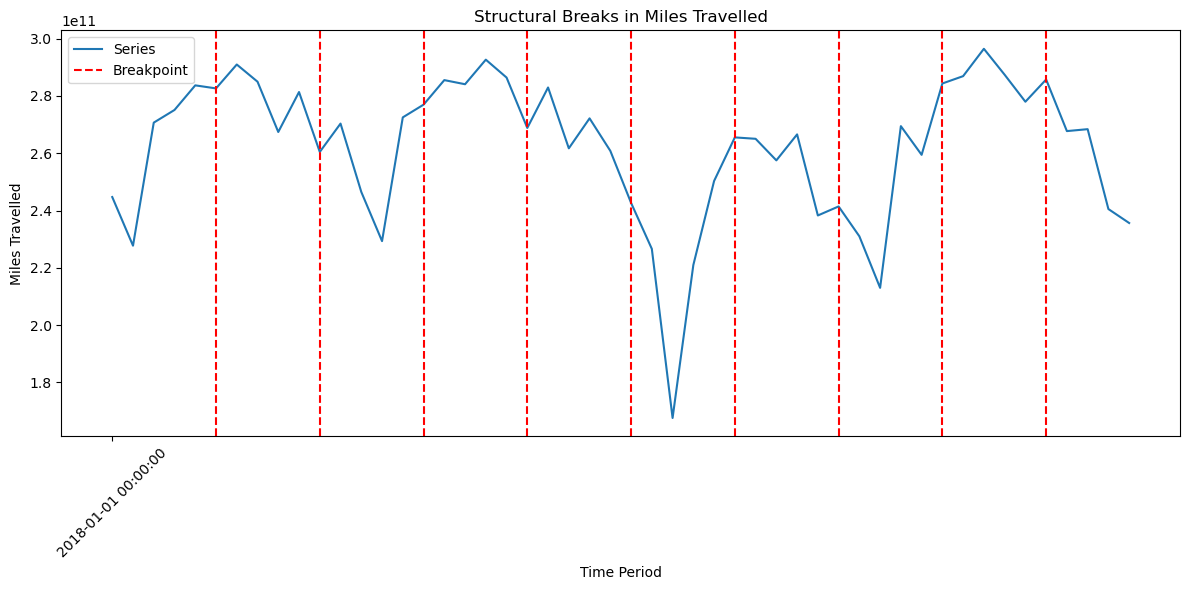

Detected break dates:
4    2018-05-01
9    2018-10-01
14   2019-03-01
19   2019-08-01
24   2020-01-01
29   2020-06-01
34   2020-11-01
39   2021-04-01
44   2021-09-01
Name: date, dtype: datetime64[ns]


In [14]:
structural_break(
    column=demand['miles_travelled'], 
    title="Structural Breaks in Miles Travelled",
    xlabel="Time Period", 
    ylabel="Miles Travelled",
    date_column=demand['date']
)

#### **Structural Break Analysis for Highway Vehicle Miles Traveled (Demand)**

**Detected Break Dates (2018):**
- A regular pattern of structural breaks was detected approximately every 5 weeks from **Jan to Nov 2018**.
- This likely reflects **seasonal fluctuations** in driving behavior, including:
  - **Weather effects** (e.g., fewer miles in winter, more in summer)
  - **Holiday-related travel spikes** (e.g., Spring Break, Memorial Day, Labor Day)
  - **Economic consistency**: No major economic shocks occurred in 2018, supporting the interpretation of cyclical, rather than structural, influences on demand.
- Suggests that **demand is highly seasonal**, with frequent shifts likely driven by **calendar effects** rather than external shocks.

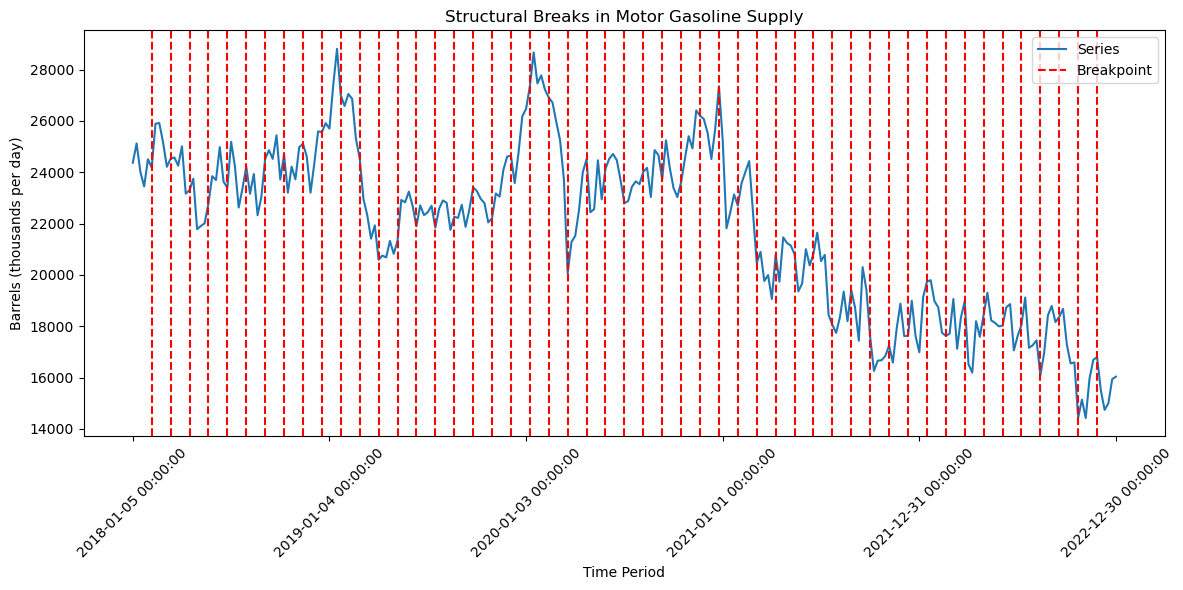

Detected break dates:
4     2018-02-02
9     2018-03-09
14    2018-04-13
19    2018-05-18
24    2018-06-22
29    2018-07-27
34    2018-08-31
39    2018-10-05
44    2018-11-09
49    2018-12-14
54    2019-01-18
59    2019-02-22
64    2019-03-29
69    2019-05-03
74    2019-06-07
79    2019-07-12
84    2019-08-16
89    2019-09-20
94    2019-10-25
99    2019-11-29
104   2020-01-03
109   2020-02-07
114   2020-03-13
119   2020-04-17
124   2020-05-22
129   2020-06-26
134   2020-07-31
139   2020-09-04
144   2020-10-09
149   2020-11-13
154   2020-12-18
159   2021-01-22
164   2021-02-26
169   2021-04-02
174   2021-05-07
179   2021-06-11
184   2021-07-16
189   2021-08-20
194   2021-09-24
199   2021-10-29
204   2021-12-03
209   2022-01-07
214   2022-02-11
219   2022-03-18
224   2022-04-22
229   2022-05-27
234   2022-07-01
239   2022-08-05
244   2022-09-09
249   2022-10-14
254   2022-11-18
Name: date, dtype: datetime64[ns]


In [15]:
structural_break(
    column=supply['motor_gasoline_barrels'], 
    title="Structural Breaks in Motor Gasoline Supply",
    xlabel="Time Period", 
    ylabel="Barrels (thousands per day)",
    date_column=supply['date']
)

#### **Structural Break Analysis for Motor Gasoline Supply (Barrels)**

**Detected Break Dates (2018–2022):**
- Structural breaks occur at **regular ~5-week intervals** across the entire period, from **Jan 2018 to Nov 2022**.
- This consistent timing suggests **cyclical adjustments** in gasoline supply, likely tied to:
  - **Seasonal demand patterns** (e.g., summer driving season, holiday travel)
  - **Inventory management cycles** by refineries and distributors
  - **Regulatory or reporting calendar effects** (e.g., monthly or quarterly adjustments)

- No abrupt structural shocks are evident, except:
  - **Early 2020** (Mar–May): aligns with **COVID-19 onset**, where sharp drops in mobility may have disrupted normal supply cycles.
  - **Early 2022**: break around **Feb 2022** may be linked to supply chain responses to **Russia–Ukraine tensions**.

Overall, the data reflects a **highly regular, seasonal supply pattern** with notable disruptions during major global events.

> Due to the large variance of data, I will try setting the penalty term to be higher at pen=15 and use the normalized values of `motor_gasoline_barrels` instead.

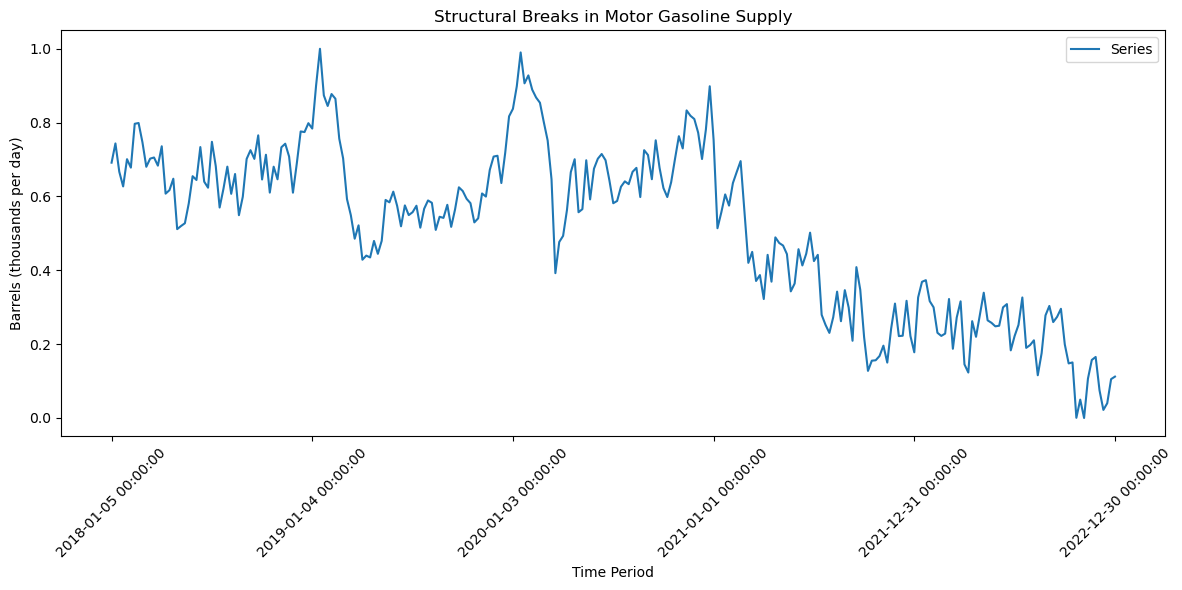

Detected break dates:
Series([], Name: date, dtype: datetime64[ns])


In [16]:
structural_break(
    column=supply['motor_gasoline_barrels_norm'], 
    title="Structural Breaks in Motor Gasoline Supply",
    xlabel="Time Period", 
    ylabel="Barrels (thousands per day)",
    date_column=supply['date'],
    penalty=15
)

> However, setting the penalty to 15 on the normalized data proved to be too insensitive, missing some meaningful structural breaks. Tuning the penalty down again...

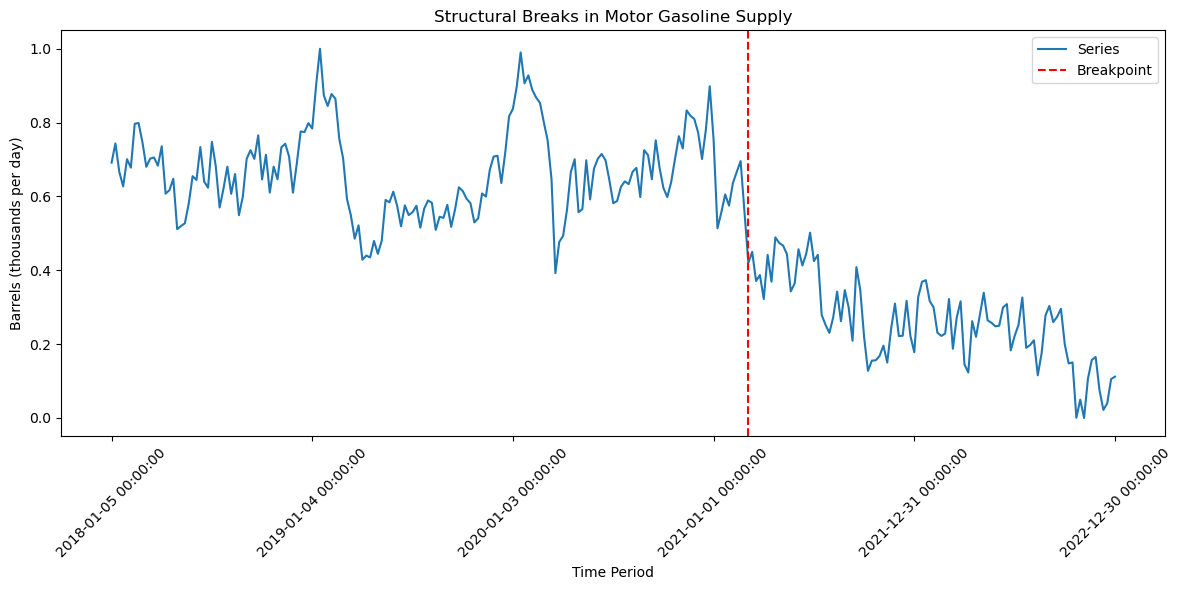

Detected break dates:
164   2021-02-26
Name: date, dtype: datetime64[ns]


In [17]:
structural_break(
    column=supply['motor_gasoline_barrels_norm'], 
    title="Structural Breaks in Motor Gasoline Supply",
    xlabel="Time Period", 
    ylabel="Barrels (thousands per day)",
    date_column=supply['date'],
    penalty=5
)

#### **Structural Break Analysis for Motor Gasoline Supply**
**Detected Break Date:**

- **2021-02-26**: This breakpoint corresponds to a period when global fuel markets were still adjusting to the aftermath of the COVID-19 pandemic. Around this time, there was a gradual recovery in demand as economies reopened, but supply chain disruptions and OPEC+ production decisions constrained output. Additionally, winter weather conditions in some regions may have temporarily affected production and distribution logistics. Together, these factors likely caused a noticeable shift in the motor gasoline supply trend.

## **1 Correlation Analysis**

### **1.1 Demand and Prices**

**Aligning the dates to test if price lags demand**

In [18]:
def match_after(dates_left, dates_right):
    # For each date in left, find the closest date in right that is >= left date
    matched_indices = []
    for d in dates_left:
        candidates = dates_right[dates_right >= d]
        if not candidates.empty:
            matched_indices.append(candidates.min())
        else:
            matched_indices.append(pd.NaT)
    return matched_indices

# Match price dates after demand dates
matched_price_dates = match_after(demand['date'], prices['date'])

# Build dataframe with demand and matched prices
demand_price_df = demand.copy()
demand_price_df['matched_price_date'] = matched_price_dates

# Merge price values on matched price dates
demand_price_df = demand_price_df.merge(prices[['date','price_norm']], left_on='matched_price_date', right_on='date', how='left', suffixes=('','_price'))

# Drop rows where no matched price date
demand_price_df = demand_price_df.dropna(subset=['price_norm'])

**Correlation of demand vs future prices**

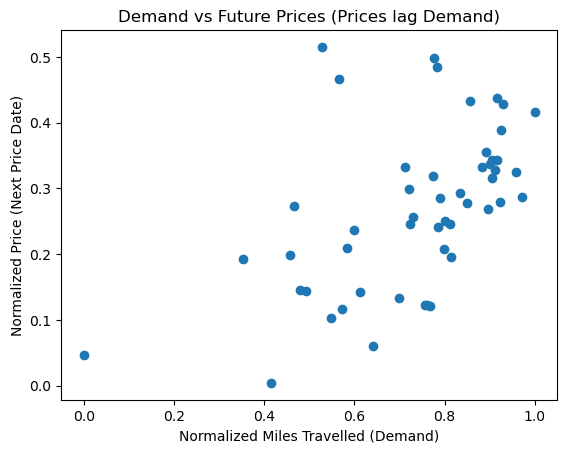

Correlation: 0.5313201535149632


In [19]:
plt.scatter(demand_price_df['miles_travelled_norm'], demand_price_df['price_norm'])
plt.xlabel('Normalized Miles Travelled (Demand)')
plt.ylabel('Normalized Price (Next Price Date)')
plt.title('Demand vs Future Prices (Prices lag Demand)')
plt.show()

print('Correlation:', demand_price_df[['miles_travelled_norm','price_norm']].corr().iloc[0,1])

**Cross-Correlation Function between demand and price**

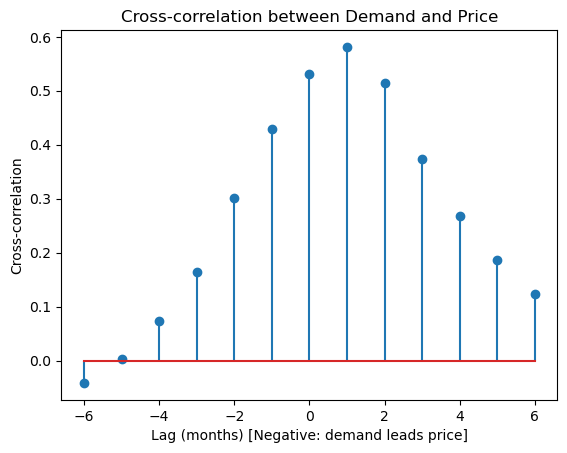

In [20]:
# Resample to monthly (first day)
prices_monthly = prices.set_index('date').resample('MS').first().dropna()
demand_monthly = demand.set_index('date').resample('MS').first().dropna()

# Align on common dates only
common_dates = prices_monthly.index.intersection(demand_monthly.index)
prices_aligned = prices_monthly.loc[common_dates]['price_norm']
demand_aligned = demand_monthly.loc[common_dates]['miles_travelled_norm']

# Compute cross-correlation
lags = np.arange(-6,7)
ccf_values = [np.corrcoef(demand_aligned.shift(lag).dropna(), prices_aligned.loc[demand_aligned.shift(lag).dropna().index])[0,1] for lag in lags]

plt.stem(lags, ccf_values)
plt.xlabel('Lag (months) [Negative: demand leads price]')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between Demand and Price')
plt.show()


**Granger Causality Test**

In [21]:
# Merge demand and price monthly (on common dates)
df_gc = pd.concat([demand_aligned, prices_aligned], axis=1).dropna()
df_gc.columns = ['demand', 'price']

maxlag = 6
print("Granger Causality: Demand causing Price")
grangercausalitytests(df_gc[['price','demand']], maxlag=maxlag, verbose=True)

print("\nGranger Causality: Price causing Demand")
grangercausalitytests(df_gc[['demand','price']], maxlag=maxlag, verbose=True)


Granger Causality: Demand causing Price

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0983  , p=0.7553  , df_denom=46, df_num=1
ssr based chi2 test:   chi2=0.1047  , p=0.7463  , df=1
likelihood ratio test: chi2=0.1046  , p=0.7464  , df=1
parameter F test:         F=0.0983  , p=0.7553  , df_denom=46, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.1668  , p=0.1269  , df_denom=43, df_num=2
ssr based chi2 test:   chi2=4.8375  , p=0.0890  , df=2
likelihood ratio test: chi2=4.6090  , p=0.0998  , df=2
parameter F test:         F=2.1668  , p=0.1269  , df_denom=43, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5110  , p=0.2264  , df_denom=40, df_num=3
ssr based chi2 test:   chi2=5.3264  , p=0.1494  , df=3
likelihood ratio test: chi2=5.0456  , p=0.1685  , df=3
parameter F test:         F=1.5110  , p=0.2264  , df_denom=40, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

{1: ({'ssr_ftest': (0.21184011010154127, 0.6474973132342644, 46.0, 1),
   'ssr_chi2test': (0.2256557694559896, 0.6347638885800595, 1),
   'lrtest': (0.22513776199892277, 0.6351527797080747, 1),
   'params_ftest': (0.21184011010155843, 0.6474973132342525, 46.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.0524347377239855, 0.35790522732345786, 43.0, 2),
   'ssr_chi2test': (2.3496217400349444, 0.3088773921398514, 2),
   'lrtest': (2.2939245896369584, 0.31760008092152936, 2),
   'params_ftest': (1.0524347377239784, 0.3579052273234588, 43.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.26964254149551353, 0.8468946274816445, 40.0, 3),
   'ssr_chi2test': (0.9504899587716852, 0.8132294283286283, 3),
   'lrtest': (0.9410066312169647, 0.8155223597166218, 3),
   'params_ftest': (0.26964254149551464, 0.8468946274816445, 40.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

### **1.2 Supply and Prices**

In [22]:
# Match price dates after supply dates
matched_price_dates = match_after(supply['date'], prices['date'])

# Build dataframe with demand and matched prices
supply_price_df = supply.copy()
supply_price_df['matched_price_date'] = matched_price_dates

# Merge price values on matched price dates
supply_price_df = supply_price_df.merge(prices[['date','price_norm']], left_on='matched_price_date', right_on='date', how='left', suffixes=('','_price'))

# Drop rows where no matched price date
supply_price_df = supply_price_df.dropna(subset=['price_norm'])

**Correlation of supply vs future prices**

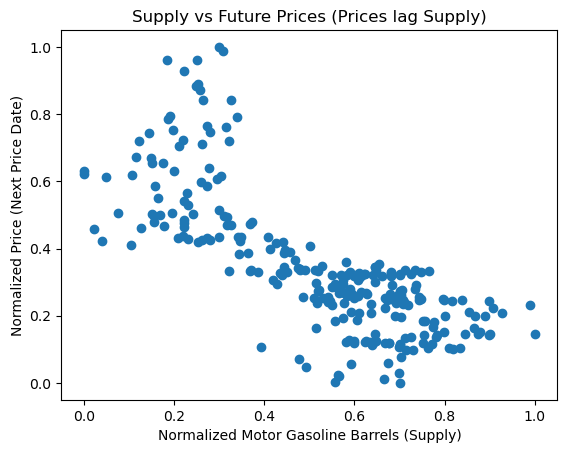

Correlation: -0.7638328028545157


In [23]:
plt.scatter(supply_price_df['motor_gasoline_barrels_norm'], supply_price_df['price_norm'])
plt.xlabel('Normalized Motor Gasoline Barrels (Supply)')
plt.ylabel('Normalized Price (Next Price Date)')
plt.title('Supply vs Future Prices (Prices lag Supply)')
plt.show()

print('Correlation:', supply_price_df[['motor_gasoline_barrels_norm','price_norm']].corr().iloc[0,1])

**Cross-Correlation Function between supply and price**

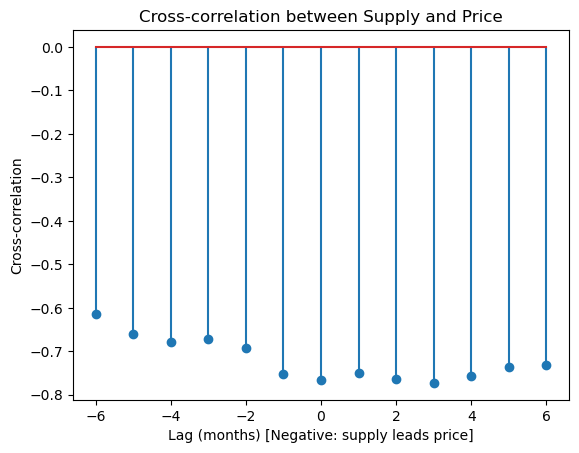

In [24]:
# Resample to monthly (first day)
prices_monthly = prices.set_index('date').resample('MS').first().dropna()
supply_monthly = supply.set_index('date').resample('MS').first().dropna()

# Align on common dates only
common_dates = prices_monthly.index.intersection(supply_monthly.index)
prices_aligned = prices_monthly.loc[common_dates]['price_norm']
supply_aligned = supply_monthly.loc[common_dates]['motor_gasoline_barrels_norm']

# Compute cross-correlation
lags = np.arange(-6,7)
ccf_values = [np.corrcoef(supply_aligned.shift(lag).dropna(), prices_aligned.loc[supply_aligned.shift(lag).dropna().index])[0,1] for lag in lags]

plt.stem(lags, ccf_values)
plt.xlabel('Lag (months) [Negative: supply leads price]')
plt.ylabel('Cross-correlation')
plt.title('Cross-correlation between Supply and Price')
plt.show()

**Granger Causality Test**

In [25]:
# Merge demand and price monthly (on common dates)
df_gc = pd.concat([supply_aligned, prices_aligned], axis=1).dropna()
df_gc.columns = ['supply', 'price']

maxlag = 6
print("Granger Causality: Supply causing Price")
grangercausalitytests(df_gc[['price','supply']], maxlag=maxlag, verbose=True)

print("\nGranger Causality: Price causing Supply")
grangercausalitytests(df_gc[['supply','price']], maxlag=maxlag, verbose=True)


Granger Causality: Supply causing Price

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3595  , p=0.5512  , df_denom=56, df_num=1
ssr based chi2 test:   chi2=0.3787  , p=0.5383  , df=1
likelihood ratio test: chi2=0.3775  , p=0.5389  , df=1
parameter F test:         F=0.3595  , p=0.5512  , df_denom=56, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.6429  , p=0.0805  , df_denom=53, df_num=2
ssr based chi2 test:   chi2=5.7844  , p=0.0555  , df=2
likelihood ratio test: chi2=5.5138  , p=0.0635  , df=2
parameter F test:         F=2.6429  , p=0.0805  , df_denom=53, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4329  , p=0.2442  , df_denom=50, df_num=3
ssr based chi2 test:   chi2=4.9006  , p=0.1792  , df=3
likelihood ratio test: chi2=4.7013  , p=0.1950  , df=3
parameter F test:         F=1.4329  , p=0.2442  , df_denom=50, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F te

{1: ({'ssr_ftest': (3.8669697237311973, 0.05420902579430263, 56.0, 1),
   'ssr_chi2test': (4.07412881607394, 0.043544715162585644, 1),
   'lrtest': (3.9396210804937937, 0.04716139934973121, 1),
   'params_ftest': (3.866969723731208, 0.0542090257943022, 56.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (3.394930283256864, 0.04099026424004645, 53.0, 2),
   'ssr_chi2test': (7.430413450147098, 0.024350406755050024, 2),
   'lrtest': (6.991562282492055, 0.030325051034167275, 2),
   'params_ftest': (3.394930283256854, 0.04099026424004686, 53.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (4.236264897847362, 0.009595846846063903, 50.0, 3),
   'ssr_chi2test': (14.488025950637978, 0.0023108038558335947, 3),
   'lrtest': (12.909285821284698, 0.004836943862612451, 3),
   'params_ftest': (4.236264897847366, 0.009595846846063884, 50.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 

**VAR model**

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 18, May, 2025
Time:                     13:52:56
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -13.8975
Nobs:                     48.0000    HQIC:                  -14.4068
Log likelihood:           169.861    FPE:                4.08864e-07
AIC:                     -14.7162    Det(Omega_mle):     2.71778e-07
--------------------------------------------------------------------
Results for equation price
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             0.099393         0.045953            2.163           0.031
L1.price          1.322833         0.168563            7.848           0.000
L1.demand         0.022556         0.045436            0.496           0.620

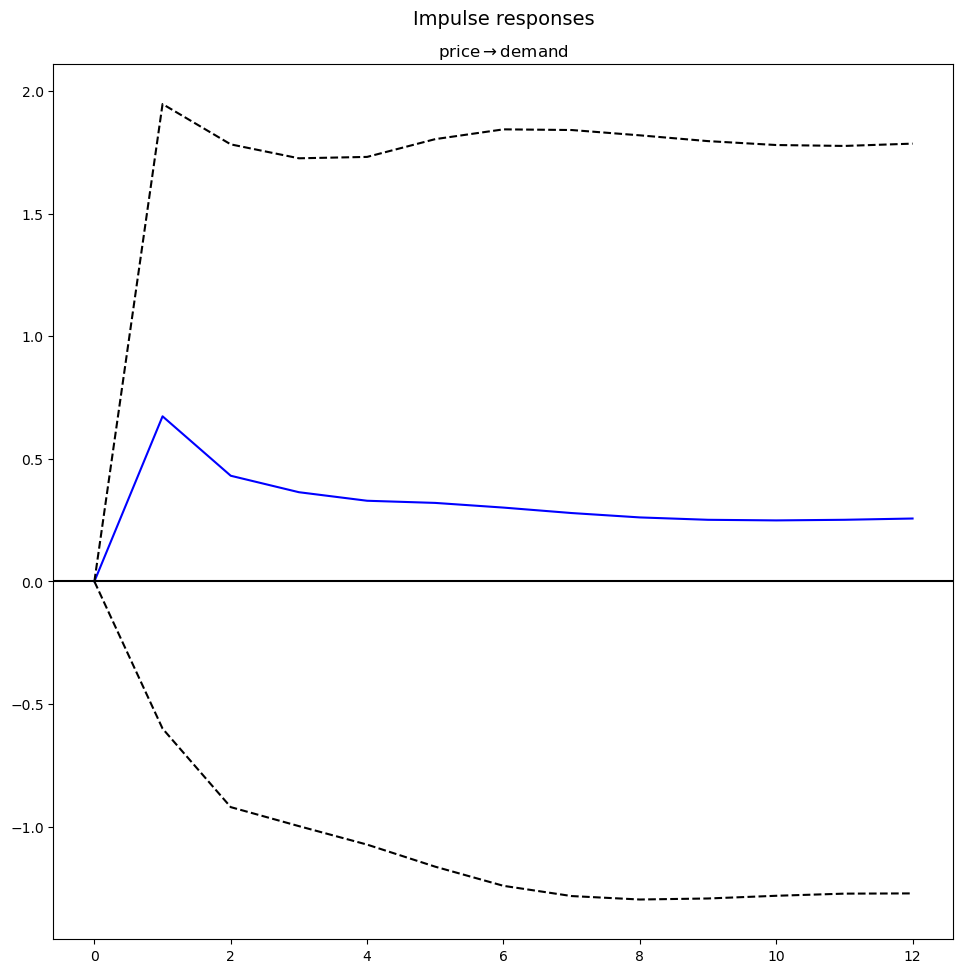

In [26]:
# Prepare monthly data for VAR - resample and align all three on month start
prices_monthly = prices.set_index('date').resample('MS').first()[['price_norm']].dropna()
demand_monthly = demand.set_index('date').resample('MS').first()[['miles_travelled_norm']].dropna()
supply_monthly = supply.set_index('date').resample('MS').first()[['motor_gasoline_barrels_norm']].dropna()

# Combine dataframes on intersection of dates
common_index = prices_monthly.index.intersection(demand_monthly.index).intersection(supply_monthly.index)
df_var = pd.concat([
    prices_monthly.loc[common_index],
    demand_monthly.loc[common_index],
    supply_monthly.loc[common_index]
], axis=1)

df_var.columns = ['price', 'demand', 'supply']

# Fit VAR
model = VAR(df_var)
results = model.fit(maxlags=6, ic='aic')

print(results.summary())

# Impulse response function: effect of a shock to price on demand
irf = results.irf(12)
irf.plot(impulse='price', response='demand')
plt.show()

## **2. Forecasting gasoline prices**

In [27]:
supply_full = supply_weekly.copy()[['Date', 'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)',
    'Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)',
    'Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)',
    'Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)',
    'Weekly U.S. Percent Utilization of Refinery Operable Capacity (Percent)'
]]

prices_full = prices_weekly.copy()[prices_weekly['Type_Clean'] == 'Regular Conventional Retail Gasoline Prices'][['Date', 'Price']].copy()

In [28]:
rename_map = {
    'Date': 'date',
    'Weekly U.S. Ending Stocks of Finished Motor Gasoline  (Thousand Barrels)': 'weekly_us_ending_stocks_gasoline',
    'Weekly U.S. Field Production of Crude Oil  (Thousand Barrels per Day)': 'weekly_us_crude_production',
    'Weekly U.S. Imports of Crude Oil  (Thousand Barrels per Day)': 'weekly_us_crude_imports',
    'Weekly U.S. Refiner and Blender Net Production of Finished Motor Gasoline  (Thousand Barrels per Day)': 'weekly_us_gasoline_net_prod',
    'Weekly U.S. Percent Utilization of Refinery Operable Capacity (Percent)': 'weekly_us_refinery_utilization_pct'
}

# Process supply_weekly
supply_full = supply_weekly[list(rename_map.keys())].copy()
supply_full.rename(columns=rename_map, inplace=True)
supply_full['date'] = pd.to_datetime(supply_full['date'], format='%b %d, %Y')


# Process prices_weekly
prices_full = prices_weekly[prices_weekly['Type_Clean'] == 'Regular Conventional Retail Gasoline Prices'][['Date', 'Price']].copy()

# Rename columns for prices
prices_rename_map = {
    'Date': 'date',
    'Price': 'price'
}
prices_full.rename(columns=prices_rename_map, inplace=True)

# Convert 'date' column in prices_full
prices_full['date'] = pd.to_datetime(prices_full['date'], format='%b %d, %Y')

prices_full.dropna(inplace=True)

In [29]:
# Match price dates after supply_full dates
matched_price_dates = match_after(supply_full['date'], prices_full['date'])

# Build dataframe with supply_full and matched prices
full_df = supply_full.copy()
full_df['matched_price_date'] = matched_price_dates

# Merge price values on matched price dates
full_df = full_df.merge(prices_full[['date','price']], left_on='matched_price_date', right_on='date', how='left', suffixes=('','_price'))

# Drop rows where no matched price date
full_df = full_df.dropna(subset=['price'])

In [30]:
full_df

,date,weekly_us_ending_stocks_gasoline,weekly_us_crude_production,weekly_us_crude_imports,weekly_us_gasoline_net_prod,weekly_us_refinery_utilization_pct,matched_price_date,date_price,price
0,2000-01-07,154476,6000,8508,8173,86.1,2000-01-10,2000-01-10,1.252
1,2000-01-07,154476,6000,8508,8173,86.1,2000-01-10,2000-01-10,1.247
2,2000-01-07,154476,6000,8508,8173,86.1,2000-01-10,2000-01-10,1.327
3,2000-01-07,154476,6000,8508,8173,86.1,2000-01-10,2000-01-10,1.317
4,2000-01-07,154476,6000,8508,8173,86.1,2000-01-10,2000-01-10,1.226
...,...,...,...,...,...,...,...,...,...
23846,2023-12-22,15562,13300,6276,9918,93.3,2023-12-25,2023-12-25,2.614
23847,2023-12-22,15562,13300,6276,9918,93.3,2023-12-25,2023-12-25,4.001
23848,2023-12-22,15562,13300,6276,9918,93.3,2023-12-25,2023-12-25,2.839
23849,2023-12-22,15562,13300,6276,9918,93.3,2023-12-25,2023-12-25,3.156


#### **Gasoline prices lag supply data by 3 days in our dataset**

As shown in `full_df`, the prices are exactly lagging the supply by 3 days for each value. For example, the supply on **2000-01-07** is matched with the price on **2000-01-10**.

This lag was identified during earlier analysis, where it became clear that supply changes lead price changes.

Although our dataset does not have sufficiently granular timestamps to definitively prove the exact lag duration, we incorporated this 3-day lag into our predictive model dataset. By aligning supply data with prices shifted by this lag, we can rationalize the relationship between supply and price movements.

This approach helps improve the predictive power of our model by effectively using supply as a leading indicator to forecast gasoline prices.

In [31]:
full_df.drop(columns=['matched_price_date', 'date_price'], inplace=True)

EDA

In [32]:
full_df

,date,weekly_us_ending_stocks_gasoline,weekly_us_crude_production,weekly_us_crude_imports,weekly_us_gasoline_net_prod,weekly_us_refinery_utilization_pct,price
0,2000-01-07,154476,6000,8508,8173,86.1,1.252
1,2000-01-07,154476,6000,8508,8173,86.1,1.247
2,2000-01-07,154476,6000,8508,8173,86.1,1.327
3,2000-01-07,154476,6000,8508,8173,86.1,1.317
4,2000-01-07,154476,6000,8508,8173,86.1,1.226
...,...,...,...,...,...,...,...
23846,2023-12-22,15562,13300,6276,9918,93.3,2.614
23847,2023-12-22,15562,13300,6276,9918,93.3,4.001
23848,2023-12-22,15562,13300,6276,9918,93.3,2.839
23849,2023-12-22,15562,13300,6276,9918,93.3,3.156


Dataset Information:
Number of rows: 23851
Number of columns: 6

Column Data Types:
weekly_us_ending_stocks_gasoline        int64
weekly_us_crude_production              int64
weekly_us_crude_imports                 int64
weekly_us_gasoline_net_prod             int64
weekly_us_refinery_utilization_pct    float64
price                                 float64
dtype: object

First few rows:
            weekly_us_ending_stocks_gasoline  weekly_us_crude_production  \
date                                                                       
2000-01-07                            154476                        6000   
2000-01-07                            154476                        6000   
2000-01-07                            154476                        6000   
2000-01-07                            154476                        6000   
2000-01-07                            154476                        6000   

            weekly_us_crude_imports  weekly_us_gasoline_net_prod  \
date    

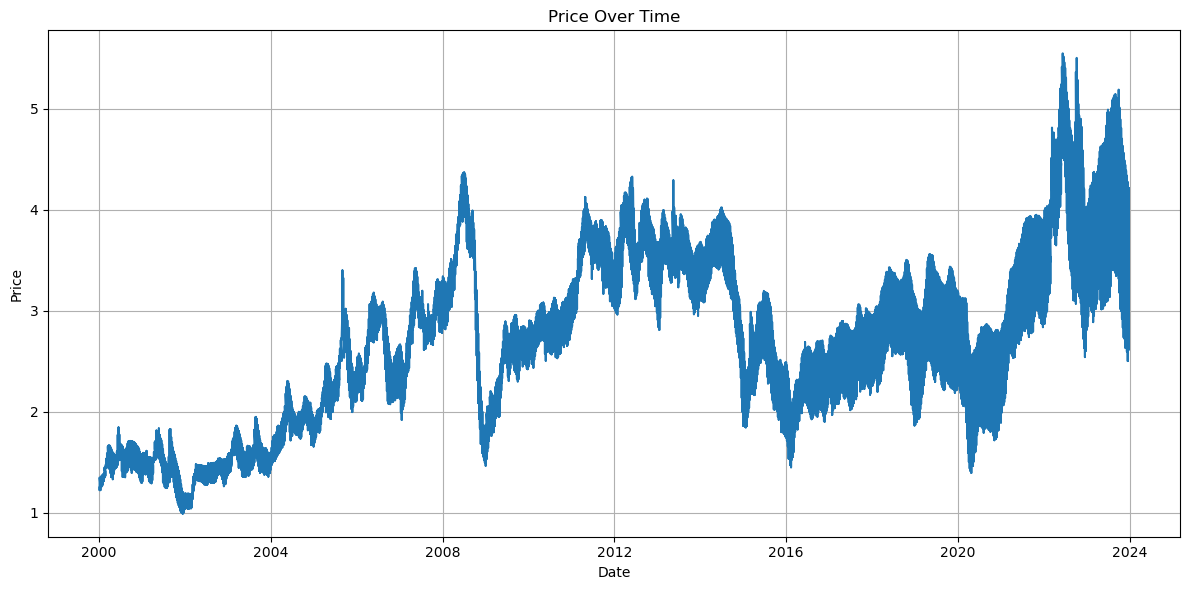

In [33]:
# Set date as the index
full_df['date'] = pd.to_datetime(full_df['date'])
full_df = full_df.set_index('date')

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of rows: {full_df.shape[0]}")
print(f"Number of columns: {full_df.shape[1]}")
print("\nColumn Data Types:")
print(full_df.dtypes)
print("\nFirst few rows:")
print(full_df.head())
print("\nDescriptive Statistics:")
print(full_df.describe())

# Check for missing values
print("\nMissing Values:")
print(full_df.isnull().sum())

# Plot the target variable (price) over time
plt.figure(figsize=(12, 6))
plt.plot(full_df.index, full_df['price'])
plt.title('Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


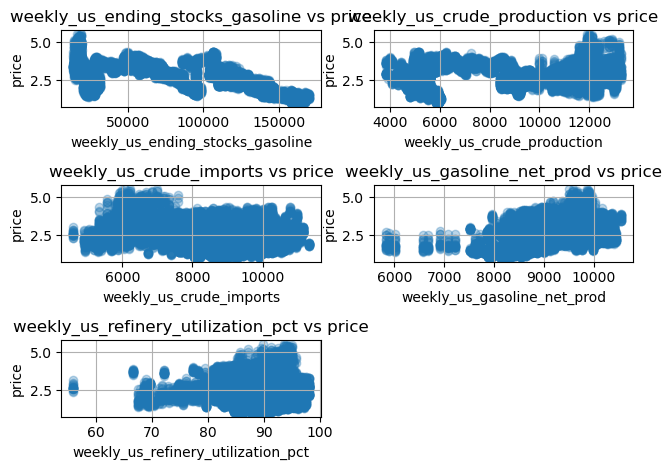

In [34]:
# Identify feature columns (all except the target 'price')
feature_cols = [col for col in full_df.columns if col != 'price']

# Create scatterplots for each feature vs target
for i, col in enumerate(feature_cols):
    plt.subplot(3, 2, i+1)
    plt.scatter(full_df[col], full_df['price'], alpha=0.3)
    plt.title(f'{col} vs price')
    plt.xlabel(col)
    plt.ylabel('price')
    plt.grid(True)

plt.tight_layout()
plt.show()

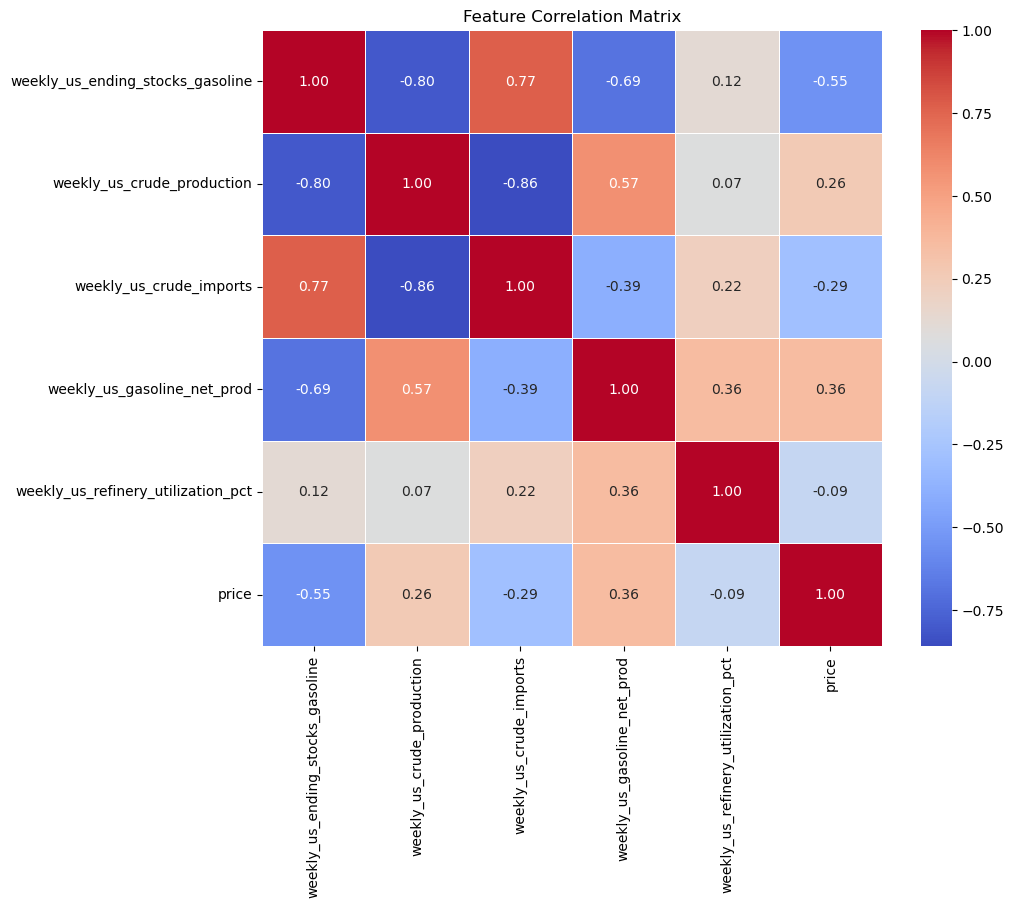

In [35]:
# Compute correlation matrix
corr_matrix = full_df.corr()
# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

In [36]:
# Check for multicollinearity with VIF (Variance Inflation Factor)
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                       for i in range(len(features))]
    return vif_data

# Calculate VIF for all features
feature_cols = [col for col in full_df.columns if col != 'price']
vif_df = calculate_vif(full_df, feature_cols)
print("\nVariance Inflation Factors (VIF):")
print(vif_df)



Variance Inflation Factors (VIF):
                             Variable         VIF
0    weekly_us_ending_stocks_gasoline   14.876610
1          weekly_us_crude_production   54.774812
2             weekly_us_crude_imports  178.530054
3         weekly_us_gasoline_net_prod  462.601760
4  weekly_us_refinery_utilization_pct  622.431961


In [38]:
# Prepare data for modeling
X = full_df.drop('price', axis=1)
y = full_df['price']

# Split the data based on time (time series split)
# Use the first 80% for training and the last 20% for testing
train_size = int(0.8 * len(full_df))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("\nData Splitting:")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Training date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing date range: {X_test.index.min()} to {X_test.index.max()}")

# Scale the features for linear models
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Data Splitting:
Training set size: 19080 samples
Testing set size: 4771 samples
Training date range: 2000-01-07 00:00:00 to 2019-05-31 00:00:00
Testing date range: 2019-05-31 00:00:00 to 2023-12-22 00:00:00


In [40]:
# Check for multicollinearity with VIF (Variance Inflation Factor)
def calculate_vif(df, features):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = features
    vif_data["VIF"] = [variance_inflation_factor(df[features].values, i) 
                       for i in range(len(features))]
    return vif_data

# Calculate VIF for all features
feature_cols = [col for col in full_df.columns if col not in ['price']]
vif_df = calculate_vif(full_df, feature_cols)
print("\nVariance Inflation Factors (VIF):")
print(vif_df)



Variance Inflation Factors (VIF):
                             Variable         VIF
0    weekly_us_ending_stocks_gasoline   14.876610
1          weekly_us_crude_production   54.774812
2             weekly_us_crude_imports  178.530054
3         weekly_us_gasoline_net_prod  462.601760
4  weekly_us_refinery_utilization_pct  622.431961


In [41]:
# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, is_scaled=True):
    # If using scaled data for training
    X_train_data = X_train_scaled if is_scaled else X_train
    X_test_data = X_test_scaled if is_scaled else X_test
    
    # Fit the model
    model.fit(X_train_data, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train_data)
    y_test_pred = model.predict(X_test_data)
    
    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print(f"\n{model_name} Results:")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Testing RMSE: {test_rmse:.4f}")
    print(f"Training MAE: {train_mae:.4f}")
    print(f"Testing MAE: {test_mae:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Testing R²: {test_r2:.4f}")
    
    # Plot actual vs predicted values for the test set
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, y_test_pred, label='Predicted')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_actual_vs_predicted.png')
    plt.close()
    
    # Plot residuals
    residuals = y_test - y_test_pred
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name}: Residuals')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_residuals.png')
    plt.close()
    
    # Plot residuals over time
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, residuals)
    plt.axhline(y=0, color='r', linestyle='-')
    plt.title(f'{model_name}: Residuals Over Time')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'{model_name.lower().replace(" ", "_")}_residuals_time.png')
    plt.close()
    
    return model, train_rmse, test_rmse, train_r2, test_r2

In [42]:
# 1. Standard Linear Regression
lr_model = LinearRegression()
lr_model, lr_train_rmse, lr_test_rmse, lr_train_r2, lr_test_r2 = evaluate_model(
    lr_model, X_train, X_test, y_train, y_test, "Linear Regression"
)


Linear Regression Results:
Training RMSE: 0.4853
Testing RMSE: 1.2811
Training MAE: 0.3834
Testing MAE: 1.0727
Training R²: 0.5821
Testing R²: -1.6999


In [43]:
new_df = full_df.copy()
epsilon = 1e-6  # small constant to avoid division by zero

# 1. Net crude supply
new_df['net_crude_supply'] = new_df['weekly_us_crude_production'] + new_df['weekly_us_crude_imports']

# 2. Refinery efficiency
new_df['refinery_efficiency'] = new_df['weekly_us_gasoline_net_prod'] / (new_df['weekly_us_refinery_utilization_pct'] + epsilon)

# 3. Stock to supply ratio
new_df['stock_to_supply_ratio'] = new_df['weekly_us_ending_stocks_gasoline'] / (new_df['net_crude_supply'] + epsilon)

In [45]:
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
lasso_results = []

for alpha in alphas:
    lasso_model = Lasso(alpha=alpha, random_state=42, max_iter=10000)
    _, _, test_rmse, _, test_r2 = evaluate_model(
        lasso_model, X_train, X_test, y_train, y_test, f"Lasso Regression (alpha={alpha})"
    )
    lasso_results.append((alpha, test_rmse, test_r2))

# Find best alpha based on lowest test RMSE
best_alpha, best_rmse, best_r2 = min(lasso_results, key=lambda x: x[1])

print(f"\nBest Lasso alpha: {best_alpha}")
print(f"Test RMSE: {best_rmse:.4f}")
print(f"Test R²: {best_r2:.4f}")

# Train final model with best alpha (optional)
lasso_model = Lasso(alpha=best_alpha, random_state=42, max_iter=10000)
lasso_model, lasso_train_rmse, lasso_test_rmse, lasso_train_r2, lasso_test_r2 = evaluate_model(
    lasso_model, X_train, X_test, y_train, y_test, "Lasso Regression (best alpha)"
)


Lasso Regression (alpha=0.001) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2758
Training MAE: 0.3839
Testing MAE: 1.0672
Training R²: 0.5821
Testing R²: -1.6779

Lasso Regression (alpha=0.01) Results:
Training RMSE: 0.4881
Testing RMSE: 1.2371
Training MAE: 0.3909
Testing MAE: 1.0249
Training R²: 0.5771
Testing R²: -1.5179

Lasso Regression (alpha=0.1) Results:
Training RMSE: 0.5723
Testing RMSE: 0.9038
Training MAE: 0.4826
Testing MAE: 0.7195
Training R²: 0.4188
Testing R²: -0.3439

Lasso Regression (alpha=1.0) Results:
Training RMSE: 0.7507
Testing RMSE: 0.9504
Training MAE: 0.6265
Testing MAE: 0.7484
Training R²: 0.0000
Testing R²: -0.4862

Lasso Regression (alpha=10.0) Results:
Training RMSE: 0.7507
Testing RMSE: 0.9504
Training MAE: 0.6265
Testing MAE: 0.7484
Training R²: 0.0000
Testing R²: -0.4862

Best Lasso alpha: 0.1
Test RMSE: 0.9038
Test R²: -0.3439

Lasso Regression (best alpha) Results:
Training RMSE: 0.5723
Testing RMSE: 0.9038
Training MAE: 0.4826
Testing MAE: 0.7195

In [46]:
# 3. Ridge Regression (L2 regularization)
# Try different alpha values
ridge_results = []

for alpha in alphas:
    ridge_model = Ridge(alpha=alpha, random_state=42)
    _, _, test_rmse, _, test_r2 = evaluate_model(
        ridge_model, X_train, X_test, y_train, y_test, f"Ridge Regression (alpha={alpha})"
    )
    ridge_results.append((alpha, test_rmse, test_r2))

# Find best alpha for Ridge
best_ridge_alpha = min(ridge_results, key=lambda x: x[1])[0]
print(f"\nBest Ridge alpha: {best_ridge_alpha}")

# Train final Ridge model with best alpha
ridge_model = Ridge(alpha=best_ridge_alpha, random_state=42)
ridge_model, ridge_train_rmse, ridge_test_rmse, ridge_train_r2, ridge_test_r2 = evaluate_model(
    ridge_model, X_train, X_test, y_train, y_test, "Ridge Regression (best alpha)"
)


Ridge Regression (alpha=0.001) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2811
Training MAE: 0.3834
Testing MAE: 1.0727
Training R²: 0.5821
Testing R²: -1.6999

Ridge Regression (alpha=0.01) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2811
Training MAE: 0.3834
Testing MAE: 1.0727
Training R²: 0.5821
Testing R²: -1.6999

Ridge Regression (alpha=0.1) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2810
Training MAE: 0.3834
Testing MAE: 1.0727
Training R²: 0.5821
Testing R²: -1.6998

Ridge Regression (alpha=1.0) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2809
Training MAE: 0.3834
Testing MAE: 1.0725
Training R²: 0.5821
Testing R²: -1.6991

Ridge Regression (alpha=10.0) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2791
Training MAE: 0.3835
Testing MAE: 1.0708
Training R²: 0.5821
Testing R²: -1.6915

Best Ridge alpha: 10.0

Ridge Regression (best alpha) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2791
Training MAE: 0.3835
Testing MAE: 1.0708
Training R²: 0.5821
Testing R²: -

In [47]:
# 4. ElasticNet Regression (mix of L1 and L2)
# Try different alpha values and L1 ratios
l1_ratios = [0.1, 0.5, 0.7, 0.9]
elastic_results = []

for alpha in [0.001, 0.01, 0.1, 1.0]:
    for l1_ratio in l1_ratios:
        elastic_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42, max_iter=10000)
        _, _, test_rmse, _, test_r2 = evaluate_model(
            elastic_model, X_train, X_test, y_train, y_test, f"ElasticNet (α={alpha}, L1={l1_ratio})"
        )
        elastic_results.append((alpha, l1_ratio, test_rmse, test_r2))

# Find best parameters for ElasticNet
best_elastic = min(elastic_results, key=lambda x: x[2])
best_elastic_alpha, best_elastic_l1 = best_elastic[0], best_elastic[1]
print(f"\nBest ElasticNet parameters - alpha: {best_elastic_alpha}, L1 ratio: {best_elastic_l1}")

# Train final ElasticNet model with best parameters
elastic_model = ElasticNet(alpha=best_elastic_alpha, l1_ratio=best_elastic_l1, random_state=42, max_iter=10000)
elastic_model, elastic_train_rmse, elastic_test_rmse, elastic_train_r2, elastic_test_r2 = evaluate_model(
    elastic_model, X_train, X_test, y_train, y_test, "ElasticNet Regression (best params)"
)


ElasticNet (α=0.001, L1=0.1) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2771
Training MAE: 0.3837
Testing MAE: 1.0689
Training R²: 0.5821
Testing R²: -1.6834

ElasticNet (α=0.001, L1=0.5) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2765
Training MAE: 0.3838
Testing MAE: 1.0681
Training R²: 0.5821
Testing R²: -1.6809

ElasticNet (α=0.001, L1=0.7) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2762
Training MAE: 0.3839
Testing MAE: 1.0678
Training R²: 0.5821
Testing R²: -1.6797

ElasticNet (α=0.001, L1=0.9) Results:
Training RMSE: 0.4853
Testing RMSE: 1.2760
Training MAE: 0.3839
Testing MAE: 1.0674
Training R²: 0.5821
Testing R²: -1.6785

ElasticNet (α=0.01, L1=0.1) Results:
Training RMSE: 0.4863
Testing RMSE: 1.2448
Training MAE: 0.3875
Testing MAE: 1.0375
Training R²: 0.5804
Testing R²: -1.5494

ElasticNet (α=0.01, L1=0.5) Results:
Training RMSE: 0.4871
Testing RMSE: 1.2390
Training MAE: 0.3890
Testing MAE: 1.0303
Training R²: 0.5789
Testing R²: -1.5256

ElasticNet (α=0.01, L1=

In [48]:
# 5. Random Forest Regression
# Don't use scaled data for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_results = []
for n_est in rf_params['n_estimators']:
    for max_d in rf_params['max_depth']:
        for min_samp in rf_params['min_samples_split']:
            rf_model = RandomForestRegressor(
                n_estimators=n_est, 
                max_depth=max_d,
                min_samples_split=min_samp,
                random_state=42
            )
            # Use unscaled data for Random Forest
            _, _, test_rmse, _, test_r2 = evaluate_model(
                rf_model, X_train, X_test, y_train, y_test, 
                f"RF (trees={n_est}, depth={max_d}, min_split={min_samp})",
                is_scaled=False
            )
            rf_results.append((n_est, max_d, min_samp, test_rmse, test_r2))

# Find best RF parameters
best_rf = min(rf_results, key=lambda x: x[3])
best_rf_n_est, best_rf_max_d, best_rf_min_samp = best_rf[0], best_rf[1], best_rf[2]
print(f"\nBest Random Forest parameters:")
print(f"n_estimators: {best_rf_n_est}, max_depth: {best_rf_max_d}, min_samples_split: {best_rf_min_samp}")

# Train final Random Forest model with best parameters
rf_model = RandomForestRegressor(
    n_estimators=best_rf_n_est, 
    max_depth=best_rf_max_d,
    min_samples_split=best_rf_min_samp,
    random_state=42
)
rf_model, rf_train_rmse, rf_test_rmse, rf_train_r2, rf_test_r2 = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test, "Random Forest (best params)",
    is_scaled=False
)


RF (trees=50, depth=None, min_split=2) Results:
Training RMSE: 0.1455
Testing RMSE: 0.9481
Training MAE: 0.1081
Testing MAE: 0.7294
Training R²: 0.9624
Testing R²: -0.4787

RF (trees=50, depth=None, min_split=5) Results:
Training RMSE: 0.1455
Testing RMSE: 0.9484
Training MAE: 0.1081
Testing MAE: 0.7296
Training R²: 0.9624
Testing R²: -0.4798

RF (trees=50, depth=None, min_split=10) Results:
Training RMSE: 0.1455
Testing RMSE: 0.9529
Training MAE: 0.1081
Testing MAE: 0.7326
Training R²: 0.9624
Testing R²: -0.4938

RF (trees=50, depth=10, min_split=2) Results:
Training RMSE: 0.1530
Testing RMSE: 0.9465
Training MAE: 0.1139
Testing MAE: 0.7277
Training R²: 0.9585
Testing R²: -0.4740

RF (trees=50, depth=10, min_split=5) Results:
Training RMSE: 0.1530
Testing RMSE: 0.9465
Training MAE: 0.1139
Testing MAE: 0.7277
Training R²: 0.9585
Testing R²: -0.4738

RF (trees=50, depth=10, min_split=10) Results:
Training RMSE: 0.1530
Testing RMSE: 0.9525
Training MAE: 0.1139
Testing MAE: 0.7328
Traini

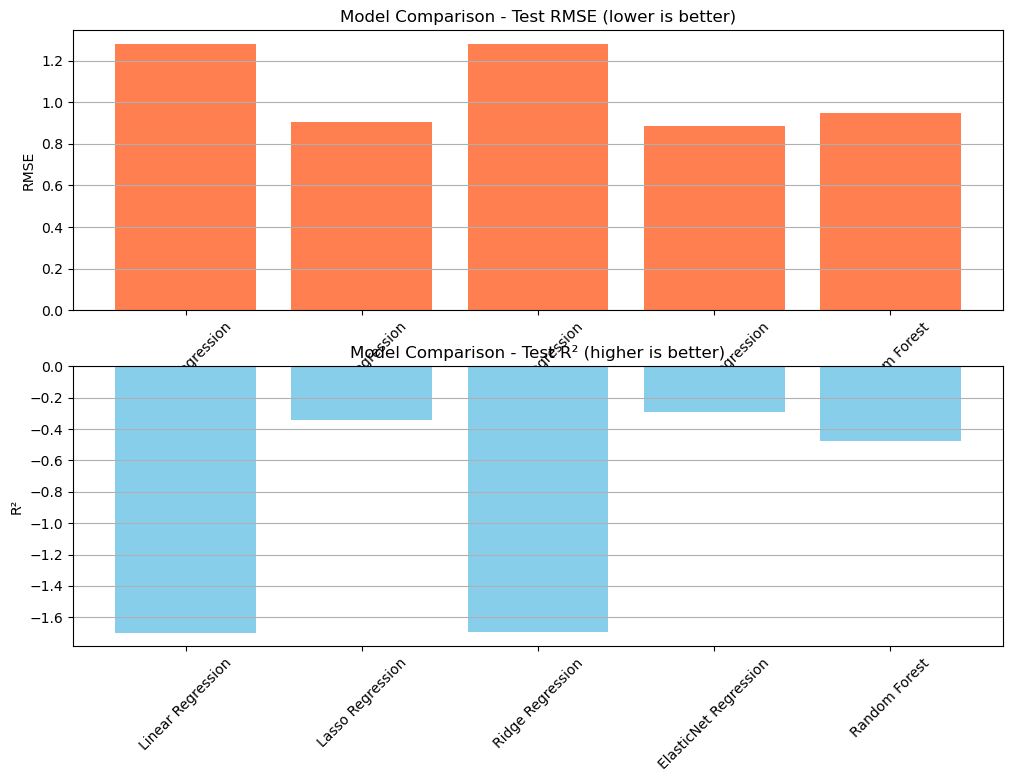

In [50]:
# Compare model performance
models = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'ElasticNet Regression', 'Random Forest']
train_rmses = [lr_train_rmse, lasso_train_rmse, ridge_train_rmse, elastic_train_rmse, rf_train_rmse]
test_rmses = [lr_test_rmse, lasso_test_rmse, ridge_test_rmse, elastic_test_rmse, rf_test_rmse]
train_r2s = [lr_train_r2, lasso_train_r2, ridge_train_r2, elastic_train_r2, rf_train_r2]
test_r2s = [lr_test_r2, lasso_test_r2, ridge_test_r2, elastic_test_r2, rf_test_r2]

# Plot model comparison
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.bar(models, test_rmses, color='coral')
plt.title('Model Comparison - Test RMSE (lower is better)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.subplot(2, 1, 2)
plt.bar(models, test_r2s, color='skyblue')
plt.title('Model Comparison - Test R² (higher is better)')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.grid(axis='y')

plt.show()

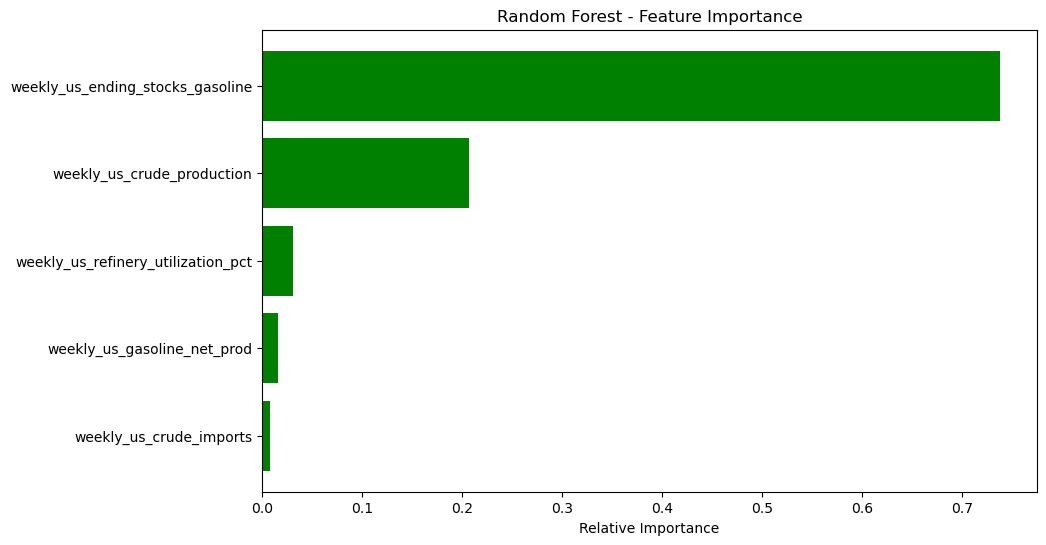

In [51]:
# Feature Importance Analysis
# For Random Forest
plt.figure(figsize=(10, 6))
importances = rf_model.feature_importances_
indices = np.argsort(importances)

plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

In [52]:
# For Linear Regression models, look at coefficients
def plot_linear_coefficients(model, columns, model_name):
    if hasattr(model, 'coef_'):
        coefs = model.coef_
        
        # Sort coefficients by absolute value
        sorted_idx = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(columns)), coefs[sorted_idx], color='b', align='center')
        plt.yticks(range(len(columns)), [columns[i] for i in sorted_idx])
        plt.xlabel('Coefficient Value')
        plt.title(f'{model_name} - Feature Coefficients')
        plt.tight_layout()
        plt.savefig(f'{model_name.lower().replace(" ", "_")}_coefficients.png')
        plt.close()
        
        # Print the coefficients
        print(f"\n{model_name} Coefficients:")
        for i, feature in enumerate(columns):
            print(f"{feature}: {coefs[i]:.4f}")

# Plot coefficients for linear models
plot_linear_coefficients(lr_model, feature_cols, "Linear Regression")
plot_linear_coefficients(lasso_model, feature_cols, "Lasso Regression")
plot_linear_coefficients(ridge_model, feature_cols, "Ridge Regression")
plot_linear_coefficients(elastic_model, feature_cols, "ElasticNet Regression")


Linear Regression Coefficients:
weekly_us_ending_stocks_gasoline: -0.9774
weekly_us_crude_production: -0.5940
weekly_us_crude_imports: 0.0416
weekly_us_gasoline_net_prod: -0.1012
weekly_us_refinery_utilization_pct: 0.0409

Lasso Regression Coefficients:
weekly_us_ending_stocks_gasoline: -0.4122
weekly_us_crude_production: -0.1393
weekly_us_crude_imports: 0.0000
weekly_us_gasoline_net_prod: 0.0000
weekly_us_refinery_utilization_pct: -0.0601

Ridge Regression Coefficients:
weekly_us_ending_stocks_gasoline: -0.9737
weekly_us_crude_production: -0.5916
weekly_us_crude_imports: 0.0417
weekly_us_gasoline_net_prod: -0.0996
weekly_us_refinery_utilization_pct: 0.0394

ElasticNet Regression Coefficients:
weekly_us_ending_stocks_gasoline: -0.1564
weekly_us_crude_production: -0.0000
weekly_us_crude_imports: -0.0000
weekly_us_gasoline_net_prod: 0.0104
weekly_us_refinery_utilization_pct: -0.0645



Linear Regression - Time Series CV Results:
CV RMSE Scores: [0.7985, 1.0114, 0.7407, 0.9966, 1.174]
Mean CV RMSE: 0.9442
Std CV RMSE: 0.1567

Lasso Regression - Time Series CV Results:
CV RMSE Scores: [1.065, 0.8655, 0.6209, 0.5532, 0.9677]
Mean CV RMSE: 0.8145
Std CV RMSE: 0.1973

Ridge Regression - Time Series CV Results:
CV RMSE Scores: [0.7994, 1.0072, 0.7382, 0.9895, 1.1735]
Mean CV RMSE: 0.9416
Std CV RMSE: 0.1562

ElasticNet Regression - Time Series CV Results:
CV RMSE Scores: [1.1617, 0.5504, 0.7107, 0.5667, 0.9661]
Mean CV RMSE: 0.7911
Std CV RMSE: 0.2378

Random Forest - Time Series CV Results:
CV RMSE Scores: [1.0007, 1.0003, 0.8963, 0.3982, 0.9426]
Mean CV RMSE: 0.8476
Std CV RMSE: 0.2281


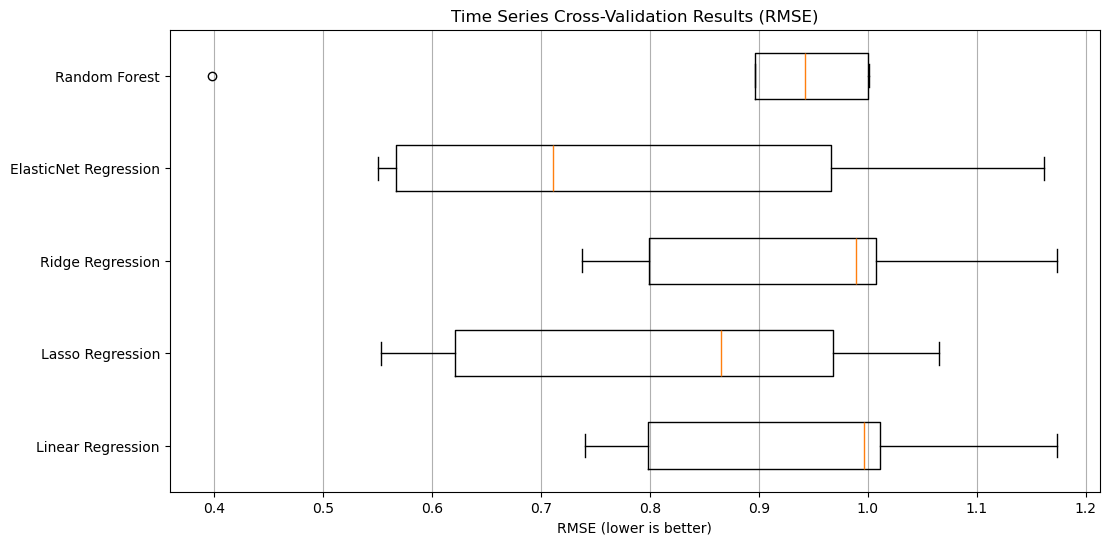


Model Performance Summary:
------------------------------------------
Model                 | Test RMSE | Test R²
------------------------------------------
Linear Regression      | 1.2811    | -1.6999
Lasso Regression       | 0.9038    | -0.3439
Ridge Regression       | 1.2791    | -1.6915
ElasticNet Regression  | 0.8854    | -0.2897
Random Forest          | 0.9465    | -0.4738
------------------------------------------

Analysis Complete!


In [53]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# Function to perform time series cross-validation
def time_series_cv(model, X, y, cv, is_scaled=True):
    cv_scores = []
    
    for train_idx, test_idx in cv.split(X):
        X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
        y_train_cv, y_test_cv = y.iloc[train_idx], y.iloc[test_idx]
        
        if is_scaled:
            # Scale features if specified
            scaler = StandardScaler()
            X_train_cv_scaled = scaler.fit_transform(X_train_cv)
            X_test_cv_scaled = scaler.transform(X_test_cv)
        else:
            # Use raw features
            X_train_cv_scaled = X_train_cv
            X_test_cv_scaled = X_test_cv
        
        # Fit model
        model.fit(X_train_cv_scaled, y_train_cv)
        
        # Predict and calculate RMSE
        y_pred = model.predict(X_test_cv_scaled)
        rmse = np.sqrt(mean_squared_error(y_test_cv, y_pred))
        cv_scores.append(rmse)
    
    return cv_scores

# Run time series cross-validation for each model
final_models = {
    'Linear Regression': (LinearRegression(), True),
    'Lasso Regression': (Lasso(alpha=best_lasso_alpha, random_state=42, max_iter=10000), True),
    'Ridge Regression': (Ridge(alpha=best_ridge_alpha, random_state=42), True),
    'ElasticNet Regression': (ElasticNet(alpha=best_elastic_alpha, l1_ratio=best_elastic_l1, random_state=42, max_iter=10000), True),
    'Random Forest': (RandomForestRegressor(n_estimators=best_rf_n_est, max_depth=best_rf_max_d, 
                                           min_samples_split=best_rf_min_samp, random_state=42), False)
}

cv_results = {}
for name, (model, is_scaled) in final_models.items():
    cv_scores = time_series_cv(model, X, y, tscv, is_scaled)
    cv_results[name] = cv_scores
    print(f"\n{name} - Time Series CV Results:")
    print(f"CV RMSE Scores: {[round(score, 4) for score in cv_scores]}")
    print(f"Mean CV RMSE: {np.mean(cv_scores):.4f}")
    print(f"Std CV RMSE: {np.std(cv_scores):.4f}")

# Plot cross-validation results
plt.figure(figsize=(12, 6))
boxplot_data = [cv_results[model] for model in final_models.keys()]
plt.boxplot(boxplot_data, labels=list(final_models.keys()), vert=False)
plt.title('Time Series Cross-Validation Results (RMSE)')
plt.xlabel('RMSE (lower is better)')
plt.grid(axis='x')
plt.show()

# Summary
print("\nModel Performance Summary:")
print("------------------------------------------")
print("Model                 | Test RMSE | Test R²")
print("------------------------------------------")
for i, model in enumerate(models):
    print(f"{model.ljust(22)} | {test_rmses[i]:.4f}    | {test_r2s[i]:.4f}")
print("------------------------------------------")

print("\nAnalysis Complete!")